In [1]:
%%capture state
from __future__ import division
from __future__ import print_function

import sys, os
sys.path.append('../')

import tensorflow as tf
import numpy as np

from models.neural_network import NeuralNetwork
from models.cnn import CNN

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

#Seed used for all calculations of training and test point indices 
SEED = 14

In [2]:
## Visualization of samples
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def visualize(image):
    plt.figure(figsize=(1, 1))
    if image.shape[-1] == 1:
        # image is in black and white
        image = image[:, :, 0]
        plt.imshow(image, cmap='Greys')
    else:
        # image is in color
        plt.imshow(image)
    plt.axis('off')
    plt.show()

#Normalize rows of a given matrix
def normalize(matrix):
    matrix_nm = np.zeros_like(matrix)
    for i in range(matrix.shape[0]):
        matrix_nm[i] = matrix[i]/np.linalg.norm(matrix[i]) 
    return matrix_nm

In [3]:
input_shape = (28,28,1)
num_classes = 10
eps=0.3

In [4]:
#Load model from disk
model_name = 'MNIST'
model_save_path = '../trained_models/' + model_name + '-model.json'
weights_save_path = '../trained_models/' + model_name + 'weights'
model = CNN(model_name=model_name, dataset='mnist')
print (model.num_params)
model.load_model(model_save_path, weights_save_path) 
#epochs = 20
#model.train(epochs=epochs)
#model.save_model(model_save_path, weights_save_path)   

3330314
Loaded model from disk


In [5]:
#Get training samples
num_train_samples = 1000
data_indices = model.gen_rand_indices(low=0, high=model.train_data.shape[0], seed=SEED, num_samples=num_train_samples)
train_data = model.train_data[data_indices]
train_data_labels = model.train_labels[data_indices]
train_data_labels_int = np.argmax(train_data_labels, axis=1)

In [6]:
num_test_samples_per_class = 10
num_test_samples = num_classes*num_test_samples_per_class

#Generate test points
test_indices = model.gen_rand_indices_all_classes(y=model.test_labels, seed=SEED, num_samples=num_test_samples_per_class)

#Get Regular, Noisy, FGSM, BIM, and CW test points
reg_data = model.test_data[test_indices]
noisy_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='Noisy', eps=eps)
fgsm_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='FGSM', eps=eps)
bim_a_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices], seed=SEED, perturbation='BIM-A', iterations=10, eps=eps)
bim_b_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices], seed=SEED, perturbation='BIM-B', iterations=10, eps=eps)
cw_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='CW', targeted=False, eps=eps)
df_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='DF')
jsma_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='JSMA')

/root/notebook/cleverhans/cleverhans/src/cleverhans/cleverhans/utils_keras.py:144: UserWarning: Please update your version to keras >= 2.1.3; support for earlier keras versions will be dropped on 2018-07-22
  "Please update your version to keras >= 2.1.3; "


In [7]:
#Whitebox CW Attack
#First get guide images
guide_indices = list()
np.random.seed(SEED)
#Generate guide images for modified CW attacks
for idx in test_indices:
    label = np.argmax(model.test_labels[idx])
    #Add 1 to the label mod 10 to get a target label
    mod_label = (label + 1) % num_classes
    #Get a test point with the target label
    guide_imgs_indices = np.where(model.train_labels[:,mod_label] == 1)[0]
    #Choose a guide image
    guide_img_idx = np.random.choice(guide_imgs_indices, 1)[0]
    guide_indices.append(guide_img_idx)


#1 Phase Attack
p1_cw_data = model.generate_perturbed_data(model.test_data[test_indices], model.train_labels[guide_indices],seed=SEED, perturbation='CW', targeted=True, x_tar = model.train_data[guide_indices], use_cos_norm_reg=True, eps=eps)

#2 Phase Attack
#Phase 1: Generate targeted adversarial images
tar_cw_data = model.generate_perturbed_data(model.test_data[test_indices], model.train_labels[guide_indices],seed=SEED, perturbation='CW', targeted=True, use_cos_norm_reg=False, eps=eps)
#Phase 2: Optimize for higher cosine sim and smaller norm of gradient vector
p2_cw_data = model.generate_perturbed_data(tar_cw_data, model.train_labels[guide_indices],seed=SEED, perturbation='CW', targeted=True, x_tar = model.train_data[guide_indices], use_cos_norm_reg=True, eps=eps)

Loss: 1734.21094, Cos: -1.00000, Norm: 147.75696
Loss: 1712.83655, Cos: -1.00000, Norm: 146.43903
Loss: 1689.73840, Cos: -1.00000, Norm: 145.00458
Loss: 1700.63953, Cos: -1.00000, Norm: 147.04990
Loss: 1669.05103, Cos: -1.00000, Norm: 144.91858
Loss: 1649.10864, Cos: -1.00000, Norm: 144.03877
Loss: 1602.41626, Cos: -1.00000, Norm: 140.54936
Loss: 1568.44458, Cos: -1.00000, Norm: 138.36403
Loss: 1529.34729, Cos: -1.00000, Norm: 135.70184
Loss: 1508.75745, Cos: -1.00000, Norm: 134.94978
Loss: 1430.53735, Cos: -1.00000, Norm: 128.45473
Loss: 1369.42212, Cos: -1.00000, Norm: 123.64934
Loss: 1313.81189, Cos: -1.00000, Norm: 119.37775
Loss: 1187.73718, Cos: -1.00000, Norm: 108.02927
Loss: 1129.73755, Cos: -1.00000, Norm: 103.50573
Loss: 987.58093, Cos: -1.00000, Norm: 90.58806
Loss: 776.69531, Cos: -1.00000, Norm: 70.73095
Loss: 546.81354, Cos: -1.00000, Norm: 48.71647
Loss: 403.69800, Cos: -1.00000, Norm: 35.20862
Loss: 249.85222, Cos: -1.00000, Norm: 19.93023
Loss: 206.33296, Cos: -1.00000

/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Loss: 1050.91479, Cos: -1.00000, Norm: 87.04962
Loss: 1037.82019, Cos: -1.00000, Norm: 86.54861
Loss: 1009.36725, Cos: -1.00000, Norm: 84.54482
Loss: 984.24591, Cos: -1.00000, Norm: 82.89311
Loss: 938.60052, Cos: -1.00000, Norm: 79.19429
Loss: 911.36560, Cos: -1.00000, Norm: 77.31232
Loss: 885.02362, Cos: -1.00000, Norm: 75.50825
Loss: 822.09174, Cos: -1.00000, Norm: 70.01636
Loss: 798.09009, Cos: -1.00000, Norm: 68.36901
Loss: 745.42401, Cos: -1.00000, Norm: 63.78279
Loss: 712.81726, Cos: -1.00000, Norm: 61.12518
Loss: 678.45679, Cos: -1.00000, Norm: 58.27676
Loss: 632.21564, Cos: -1.00000, Norm: 54.23718
Loss: 547.89917, Cos: -1.00000, Norm: 46.30482
Loss: 512.20074, Cos: -1.00000, Norm: 43.17237
Loss: 443.51279, Cos: -1.00000, Norm: 36.74141
Loss: 392.09732, Cos: -1.00000, Norm: 31.97267
Loss: 351.88840, Cos: -1.00000, Norm: 28.25507
Loss: 329.04724, Cos: -1.00000, Norm: 26.25499
Loss: 292.85138, Cos: -1.00000, Norm: 22.74924
Loss: 256.15125, Cos: -1.00000, Norm: 19.10978
Loss: 258.

Loss: 1384.08606, Cos: -1.00000, Norm: 124.32014
Loss: 1344.16589, Cos: -1.00000, Norm: 120.99143
Loss: 1295.26526, Cos: -1.00000, Norm: 116.73359
Loss: 1251.75781, Cos: -1.00000, Norm: 112.99119
Loss: 1214.92615, Cos: -1.00000, Norm: 109.91631
Loss: 1159.77026, Cos: -1.00000, Norm: 105.06635
Loss: 990.45325, Cos: -1.00000, Norm: 88.80903
Loss: 918.42950, Cos: -1.00000, Norm: 82.29920
Loss: 840.30981, Cos: -1.00000, Norm: 75.22372
Loss: 711.70465, Cos: -1.00000, Norm: 63.09390
Loss: 517.97089, Cos: -1.00000, Norm: 44.35841
Loss: 427.90182, Cos: -1.00000, Norm: 35.82681
Loss: 370.41769, Cos: -1.00000, Norm: 30.48817
Loss: 305.70615, Cos: -1.00000, Norm: 24.28386
Loss: 287.31055, Cos: -1.00000, Norm: 22.48089
Loss: 222.07903, Cos: -1.00000, Norm: 15.88351
Loss: 217.84686, Cos: -1.00000, Norm: 15.26327
Loss: 216.58234, Cos: -1.00000, Norm: 14.88651
Loss: 211.80650, Cos: -1.00000, Norm: 14.15010
Loss: 231.66385, Cos: -1.00000, Norm: 15.88054
Loss: 234.37451, Cos: -1.00000, Norm: 15.82576
L

Loss: 1190.29626, Cos: -1.00000, Norm: 107.10245
Loss: 1140.13965, Cos: -1.00000, Norm: 102.90542
Loss: 1025.35388, Cos: -1.00000, Norm: 92.24199
Loss: 852.39453, Cos: -1.00000, Norm: 75.73811
Loss: 784.01300, Cos: -1.00000, Norm: 69.58587
Loss: 672.37268, Cos: -1.00000, Norm: 59.08531
Loss: 527.65247, Cos: -1.00000, Norm: 45.20039
Loss: 457.59998, Cos: -1.00000, Norm: 38.36656
Loss: 405.69089, Cos: -1.00000, Norm: 32.89932
Loss: 386.71921, Cos: -1.00000, Norm: 30.99452
Loss: 349.13391, Cos: -1.00000, Norm: 27.33855
Loss: 315.77826, Cos: -1.00000, Norm: 24.07914
Loss: 281.48285, Cos: -1.00000, Norm: 20.74482
Loss: 253.95511, Cos: -1.00000, Norm: 18.03085
Loss: 242.30371, Cos: -1.00000, Norm: 16.87839
Loss: 232.76523, Cos: -1.00000, Norm: 15.97186
Loss: 203.44153, Cos: -1.00000, Norm: 13.08055
Loss: 205.85168, Cos: -1.00000, Norm: 13.36174
Loss: 194.65198, Cos: -1.00000, Norm: 12.27003
Loss: 187.47498, Cos: -1.00000, Norm: 11.42433
Loss: 187.03192, Cos: -1.00000, Norm: 11.26339
Loss: 19

Loss: 424.17429, Cos: -1.00000, Norm: 35.46964
Loss: 321.27383, Cos: -1.00000, Norm: 25.48890
Loss: 284.08286, Cos: -1.00000, Norm: 21.95164
Loss: 263.45090, Cos: -1.00000, Norm: 19.97423
Loss: 245.92078, Cos: -1.00000, Norm: 18.26229
Loss: 239.39182, Cos: -1.00000, Norm: 17.62886
Loss: 223.79224, Cos: -1.00000, Norm: 16.06520
Loss: 201.48624, Cos: -1.00000, Norm: 13.77619
Loss: 195.64116, Cos: -1.00000, Norm: 13.06461
Loss: 165.42230, Cos: -1.00000, Norm: 9.89413
Loss: 148.58585, Cos: -1.00000, Norm: 8.06727
Loss: 143.37816, Cos: -1.00000, Norm: 7.39625
Loss: 143.39954, Cos: -1.00000, Norm: 7.26395
Loss: 127.80677, Cos: -1.00000, Norm: 5.58230
Loss: 128.04228, Cos: -1.00000, Norm: 5.50097
Loss: 128.18047, Cos: -1.00000, Norm: 5.42787
Loss: 128.35458, Cos: -1.00000, Norm: 5.37586
Loss: 127.48561, Cos: -1.00000, Norm: 5.22914
Loss: 127.44490, Cos: -1.00000, Norm: 5.17930
Loss: 127.50366, Cos: -1.00000, Norm: 5.14529
Loss: 127.45892, Cos: -1.00000, Norm: 5.11601
Loss: 127.19726, Cos: -1.

Loss: 198.25182, Cos: -1.00000, Norm: 15.99257
Loss: 193.35283, Cos: -1.00000, Norm: 15.56889
Loss: 188.48404, Cos: -1.00000, Norm: 15.14763
Loss: 175.26703, Cos: -1.00000, Norm: 13.86923
Loss: 173.78947, Cos: -1.00000, Norm: 13.75285
Loss: 153.05000, Cos: -1.00000, Norm: 11.69689
Loss: 148.93135, Cos: -1.00000, Norm: 11.29625
Loss: 148.51134, Cos: -1.00000, Norm: 11.26614
Loss: 147.99530, Cos: -1.00000, Norm: 11.22810
Loss: 144.26904, Cos: -1.00000, Norm: 10.86917
Loss: 140.56317, Cos: -1.00000, Norm: 10.50724
Loss: 140.57962, Cos: -1.00000, Norm: 10.51954
Loss: 139.93831, Cos: -1.00000, Norm: 10.46722
Loss: 139.50835, Cos: -1.00000, Norm: 10.43738
Loss: 139.55724, Cos: -1.00000, Norm: 10.45782
Loss: 130.57181, Cos: -1.00000, Norm: 9.56653
Loss: 130.22943, Cos: -1.00000, Norm: 9.54207
Loss: 130.07875, Cos: -1.00000, Norm: 9.53892
Loss: 129.63249, Cos: -1.00000, Norm: 9.50952
Loss: 128.86423, Cos: -1.00000, Norm: 9.45104
Loss: 128.18990, Cos: -1.00000, Norm: 9.40301
Loss: 120.64816, Co

Loss: 38.80608, Cos: -0.99139, Norm: 0.17228
Loss: 38.65695, Cos: -0.99140, Norm: 0.15230
Loss: 38.51602, Cos: -0.99128, Norm: 0.13421
Loss: 38.37687, Cos: -0.99127, Norm: 0.11688
Loss: 38.25417, Cos: -0.99128, Norm: 0.10141
Loss: 38.11927, Cos: -0.99130, Norm: 0.08412
Loss: 38.00086, Cos: -0.99122, Norm: 0.06709
Loss: 37.91826, Cos: -0.99057, Norm: 0.05300
Loss: 37.84747, Cos: -0.99008, Norm: 0.04032
Loss: 37.79483, Cos: -0.98998, Norm: 0.03119
Loss: 37.73130, Cos: -0.98996, Norm: 0.02610
Loss: 37.63018, Cos: -0.98986, Norm: 0.02400
Loss: 37.50430, Cos: -0.98980, Norm: 0.02369
Loss: 37.37299, Cos: -0.98978, Norm: 0.02474
Loss: 37.24790, Cos: -0.98974, Norm: 0.02701
Loss: 37.14420, Cos: -0.99031, Norm: 0.03050
Loss: 37.04425, Cos: -0.99027, Norm: 0.03379
Loss: 36.95779, Cos: -0.99029, Norm: 0.03674
Loss: 36.87581, Cos: -0.99017, Norm: 0.03835
Loss: 36.79955, Cos: -0.99014, Norm: 0.03867
Loss: 36.71906, Cos: -0.99013, Norm: 0.03816
Loss: 36.63762, Cos: -0.99022, Norm: 0.03742
Loss: 36.5

Loss: 1626.73230, Cos: -1.00000, Norm: 150.11134
Loss: 1561.93457, Cos: -1.00000, Norm: 144.20300
Loss: 1539.99634, Cos: -1.00000, Norm: 142.62874
Loss: 1513.24231, Cos: -1.00000, Norm: 140.62859
Loss: 1391.41138, Cos: -1.00000, Norm: 129.13953
Loss: 1291.41260, Cos: -1.00000, Norm: 119.86728
Loss: 1244.92053, Cos: -1.00000, Norm: 115.96442
Loss: 1189.94800, Cos: -1.00000, Norm: 111.27544
Loss: 1089.12659, Cos: -1.00000, Norm: 102.02248
Loss: 1007.75336, Cos: -1.00000, Norm: 94.74907
Loss: 807.76093, Cos: -1.00000, Norm: 75.58276
Loss: 603.83698, Cos: -1.00000, Norm: 55.92462
Loss: 383.27713, Cos: -1.00000, Norm: 34.44398
Loss: 310.23935, Cos: -1.00000, Norm: 27.63401
Loss: 219.59460, Cos: -1.00000, Norm: 18.98895
Loss: 194.34845, Cos: -1.00000, Norm: 16.36267
Loss: 168.15599, Cos: -1.00000, Norm: 13.65738
Loss: 148.87946, Cos: -1.00000, Norm: 11.63615
Loss: 154.20096, Cos: -1.00000, Norm: 12.06242
Loss: 158.30159, Cos: -1.00000, Norm: 12.37915
Loss: 157.44612, Cos: -1.00000, Norm: 12.

Loss: 502.81281, Cos: -1.00000, Norm: 46.43248
Loss: 325.61029, Cos: -1.00000, Norm: 29.52475
Loss: 200.80304, Cos: -1.00000, Norm: 16.96768
Loss: 96.15234, Cos: -1.00000, Norm: 6.32538
Loss: 68.92471, Cos: -1.00000, Norm: 3.43752
Loss: 51.86130, Cos: -1.00000, Norm: 1.57834
Loss: 44.33839, Cos: -1.00000, Norm: 0.68541
Loss: 41.72102, Cos: -1.00000, Norm: 0.29482
Loss: 41.34644, Cos: -1.00000, Norm: 0.13999
Loss: 41.72734, Cos: -1.00000, Norm: 0.07181
Loss: 42.37795, Cos: -1.00000, Norm: 0.04124
Loss: 43.05938, Cos: -1.00000, Norm: 0.02392
Loss: 43.72822, Cos: -1.00000, Norm: 0.01510
Loss: 44.33579, Cos: -1.00000, Norm: 0.00949
Loss: 44.87785, Cos: -1.00000, Norm: 0.00630
Loss: 45.34724, Cos: -1.00000, Norm: 0.00439
Loss: 45.74253, Cos: -1.00000, Norm: 0.00318
Loss: 46.06591, Cos: -1.00000, Norm: 0.00240
Loss: 1365.55884, Cos: -1.00000, Norm: 112.78736
Loss: 1355.27405, Cos: -1.00000, Norm: 112.72669
Loss: 1332.56506, Cos: -1.00000, Norm: 111.41093
Loss: 1316.33936, Cos: -1.00000, Norm

Loss: 53.92122, Cos: -1.00000, Norm: 2.67544
Loss: 43.49738, Cos: -1.00000, Norm: 1.52810
Loss: 38.98346, Cos: -1.00000, Norm: 0.98020
Loss: 37.07346, Cos: -1.00000, Norm: 0.70032
Loss: 35.71474, Cos: -1.00000, Norm: 0.48254
Loss: 35.26234, Cos: -1.00000, Norm: 0.36190
Loss: 35.15069, Cos: -1.00000, Norm: 0.28144
Loss: 35.18027, Cos: -1.00000, Norm: 0.22086
Loss: 35.27583, Cos: -1.00000, Norm: 0.17237
Loss: 35.44538, Cos: -1.00000, Norm: 0.13651
Loss: 35.65688, Cos: -1.00000, Norm: 0.10985
Loss: 35.89791, Cos: -1.00000, Norm: 0.09092
Loss: 36.17979, Cos: -1.00000, Norm: 0.08066
Loss: 36.40826, Cos: -1.00000, Norm: 0.06940
Loss: 36.60374, Cos: -1.00000, Norm: 0.05897
Loss: 1464.24585, Cos: -1.00000, Norm: 129.25191
Loss: 1438.07800, Cos: -1.00000, Norm: 127.81554
Loss: 1362.71619, Cos: -1.00000, Norm: 121.44402
Loss: 1331.85327, Cos: -1.00000, Norm: 119.55976
Loss: 1264.71680, Cos: -1.00000, Norm: 114.07920
Loss: 1236.06458, Cos: -1.00000, Norm: 112.40428
Loss: 1195.72375, Cos: -1.00000

Loss: 45.63006, Cos: -0.99953, Norm: 0.00654
Loss: 45.47640, Cos: -0.99953, Norm: 0.00638
Loss: 45.32529, Cos: -0.99953, Norm: 0.00622
Loss: 45.17680, Cos: -0.99953, Norm: 0.00608
Loss: 45.03044, Cos: -0.99953, Norm: 0.00593
Loss: 44.88672, Cos: -0.99953, Norm: 0.00582
Loss: 44.74487, Cos: -0.99953, Norm: 0.00569
Loss: 44.60499, Cos: -0.99953, Norm: 0.00555
Loss: 44.46734, Cos: -0.99953, Norm: 0.00543
Loss: 44.33165, Cos: -0.99953, Norm: 0.00532
Loss: 44.19810, Cos: -0.99953, Norm: 0.00523
Loss: 44.06623, Cos: -0.99953, Norm: 0.00512
Loss: 1008.46606, Cos: -1.00000, Norm: 87.31047
Loss: 968.02289, Cos: -1.00000, Norm: 84.45977
Loss: 938.01074, Cos: -1.00000, Norm: 82.64796
Loss: 810.84290, Cos: -1.00000, Norm: 71.13648
Loss: 789.45001, Cos: -1.00000, Norm: 70.07974
Loss: 730.06921, Cos: -1.00000, Norm: 65.27493
Loss: 656.88812, Cos: -1.00000, Norm: 59.12934
Loss: 542.48419, Cos: -1.00000, Norm: 48.79731
Loss: 511.01044, Cos: -1.00000, Norm: 46.15169
Loss: 523.90192, Cos: -1.00000, Norm

Loss: 228.96971, Cos: -1.00000, Norm: 15.07683
Loss: 220.59665, Cos: -1.00000, Norm: 14.24575
Loss: 224.20824, Cos: -1.00000, Norm: 14.61462
Loss: 210.17668, Cos: -1.00000, Norm: 13.21838
Loss: 199.97630, Cos: -1.00000, Norm: 12.21209
Loss: 197.72464, Cos: -1.00000, Norm: 12.00442
Loss: 196.46445, Cos: -1.00000, Norm: 11.90353
Loss: 201.07388, Cos: -1.00000, Norm: 12.39845
Loss: 197.02170, Cos: -1.00000, Norm: 12.05502
Loss: 193.31305, Cos: -1.00000, Norm: 11.71710
Loss: 190.04605, Cos: -1.00000, Norm: 11.39031
Loss: 192.16199, Cos: -1.00000, Norm: 11.60384
Loss: 191.21501, Cos: -1.00000, Norm: 11.51204
Loss: 193.24033, Cos: -1.00000, Norm: 11.71722
Loss: 184.69516, Cos: -1.00000, Norm: 10.86405
Loss: 189.20316, Cos: -1.00000, Norm: 11.31344
Loss: 184.61673, Cos: -1.00000, Norm: 10.84896
Loss: 172.61810, Cos: -1.00000, Norm: 9.63742
Loss: 164.60931, Cos: -1.00000, Norm: 8.81413
Loss: 148.05829, Cos: -1.00000, Norm: 7.11985
Loss: 127.06828, Cos: -1.00000, Norm: 4.95827
Loss: 108.16275, 

Loss: 390.72589, Cos: -1.00000, Norm: 32.11046
Loss: 252.99028, Cos: -1.00000, Norm: 18.90204
Loss: 203.74948, Cos: -1.00000, Norm: 14.28282
Loss: 168.60251, Cos: -1.00000, Norm: 10.92589
Loss: 141.35172, Cos: -1.00000, Norm: 8.21143
Loss: 147.04968, Cos: -1.00000, Norm: 8.71076
Loss: 145.50223, Cos: -1.00000, Norm: 8.45603
Loss: 143.94101, Cos: -1.00000, Norm: 8.22061
Loss: 131.10724, Cos: -1.00000, Norm: 6.88610
Loss: 129.39827, Cos: -1.00000, Norm: 6.67386
Loss: 127.09544, Cos: -1.00000, Norm: 6.40122
Loss: 127.53356, Cos: -1.00000, Norm: 6.39729
Loss: 127.28091, Cos: -1.00000, Norm: 6.32768
Loss: 95.94650, Cos: -1.00000, Norm: 3.14699
Loss: 96.31584, Cos: -1.00000, Norm: 3.13438
Loss: 96.66177, Cos: -1.00000, Norm: 3.12574
Loss: 96.96928, Cos: -1.00000, Norm: 3.12103
Loss: 125.85434, Cos: -1.00000, Norm: 5.98123
Loss: 126.27850, Cos: -1.00000, Norm: 6.00120
Loss: 126.28386, Cos: -1.00000, Norm: 5.99108
Loss: 126.26522, Cos: -1.00000, Norm: 5.98924
Loss: 96.98012, Cos: -1.00000, Nor

Loss: 1734.50391, Cos: -1.00001, Norm: 154.04951
Loss: 1693.87170, Cos: -1.00001, Norm: 151.05276
Loss: 1659.66394, Cos: -1.00001, Norm: 148.78133
Loss: 1621.63977, Cos: -1.00001, Norm: 146.18588
Loss: 1593.08691, Cos: -1.00001, Norm: 144.54308
Loss: 1530.63733, Cos: -1.00001, Norm: 139.49437
Loss: 1518.28931, Cos: -1.00001, Norm: 139.43669
Loss: 1420.94434, Cos: -1.00001, Norm: 130.84793
Loss: 1376.97327, Cos: -1.00001, Norm: 127.53590
Loss: 1344.21960, Cos: -1.00001, Norm: 125.27735
Loss: 1280.83826, Cos: -1.00001, Norm: 119.86318
Loss: 1197.12952, Cos: -1.00001, Norm: 112.35565
Loss: 1160.84741, Cos: -1.00001, Norm: 109.55749
Loss: 1014.55426, Cos: -1.00001, Norm: 95.73375
Loss: 823.60181, Cos: -1.00001, Norm: 77.29071
Loss: 627.52618, Cos: -1.00001, Norm: 58.27194
Loss: 494.12170, Cos: -1.00000, Norm: 45.53995
Loss: 348.35223, Cos: -1.00000, Norm: 31.52597
Loss: 242.46994, Cos: -1.00000, Norm: 21.41117
Loss: 202.99202, Cos: -0.99999, Norm: 17.60037
Loss: 179.78546, Cos: -0.99999, N

Loss: 2264.25830, Cos: -1.00000, Norm: 201.96376
Loss: 2231.14722, Cos: -1.00000, Norm: 199.44995
Loss: 2195.57520, Cos: -1.00000, Norm: 196.72041
Loss: 2153.73022, Cos: -1.00000, Norm: 193.37056
Loss: 2124.63306, Cos: -1.00000, Norm: 191.31987
Loss: 2068.17212, Cos: -1.00000, Norm: 186.57672
Loss: 2039.32227, Cos: -1.00000, Norm: 184.60832
Loss: 1997.33679, Cos: -1.00000, Norm: 181.36880
Loss: 1974.53381, Cos: -1.00000, Norm: 180.08275
Loss: 1889.40002, Cos: -1.00000, Norm: 172.58279
Loss: 1757.33020, Cos: -1.00000, Norm: 160.33368
Loss: 1664.08118, Cos: -1.00000, Norm: 151.96674
Loss: 1513.06152, Cos: -1.00000, Norm: 137.84297
Loss: 1455.78052, Cos: -1.00000, Norm: 133.05086
Loss: 1411.12866, Cos: -1.00000, Norm: 129.52759
Loss: 1306.73035, Cos: -1.00000, Norm: 120.00271
Loss: 1201.60120, Cos: -1.00000, Norm: 110.41196
Loss: 1065.43506, Cos: -1.00000, Norm: 97.74852
Loss: 811.28308, Cos: -1.00000, Norm: 73.17733
Loss: 777.21667, Cos: -1.00000, Norm: 70.55086
Loss: 664.96515, Cos: -1.

Loss: 246.27393, Cos: -1.00000, Norm: 20.56329
Loss: 205.10553, Cos: -1.00000, Norm: 16.27245
Loss: 203.30438, Cos: -1.00000, Norm: 15.93960
Loss: 186.22882, Cos: -1.00000, Norm: 14.10715
Loss: 150.36078, Cos: -1.00000, Norm: 10.42290
Loss: 121.01086, Cos: -1.00000, Norm: 7.41377
Loss: 95.55087, Cos: -1.00000, Norm: 4.81283
Loss: 77.00732, Cos: -1.00000, Norm: 2.91899
Loss: 64.25529, Cos: -1.00000, Norm: 1.61602
Loss: 57.94046, Cos: -1.00000, Norm: 0.96508
Loss: 54.40902, Cos: -1.00000, Norm: 0.59871
Loss: 52.55187, Cos: -1.00000, Norm: 0.40446
Loss: 51.27046, Cos: -1.00000, Norm: 0.27134
Loss: 50.46819, Cos: -1.00000, Norm: 0.18880
Loss: 49.93913, Cos: -1.00000, Norm: 0.13557
Loss: 49.59671, Cos: -1.00000, Norm: 0.10249
Loss: 49.34634, Cos: -1.00000, Norm: 0.07977
Loss: 49.15607, Cos: -1.00000, Norm: 0.06398
Loss: 48.99598, Cos: -1.00000, Norm: 0.05195
Loss: 48.86335, Cos: -1.00000, Norm: 0.04330
Loss: 48.74281, Cos: -1.00000, Norm: 0.03639
Loss: 48.63360, Cos: -1.00000, Norm: 0.03109

Loss: 238.72903, Cos: -1.00000, Norm: 18.01550
Loss: 235.78142, Cos: -1.00000, Norm: 17.82186
Loss: 228.14005, Cos: -0.99999, Norm: 17.16985
Loss: 229.75793, Cos: -0.99999, Norm: 17.46090
Loss: 219.14011, Cos: -0.99999, Norm: 16.54074
Loss: 217.34433, Cos: -0.99999, Norm: 16.52342
Loss: 214.20760, Cos: -0.99999, Norm: 16.17170
Loss: 197.83757, Cos: -0.99999, Norm: 14.50451
Loss: 171.61737, Cos: -0.99999, Norm: 11.85988
Loss: 148.36798, Cos: -0.99999, Norm: 9.52084
Loss: 134.53465, Cos: -0.99999, Norm: 8.13170
Loss: 111.01144, Cos: -0.99999, Norm: 5.78390
Loss: 92.05909, Cos: -0.99999, Norm: 3.90280
Loss: 77.59247, Cos: -0.99999, Norm: 2.47586
Loss: 69.91190, Cos: -0.99999, Norm: 1.73029
Loss: 64.27451, Cos: -0.99999, Norm: 1.19015
Loss: 60.92155, Cos: -0.99999, Norm: 0.87876
Loss: 57.90009, Cos: -0.99999, Norm: 0.60011
Loss: 55.95907, Cos: -0.99999, Norm: 0.42863
Loss: 54.69391, Cos: -0.99999, Norm: 0.32363
Loss: 53.68280, Cos: -0.99999, Norm: 0.24277
Loss: 53.02123, Cos: -0.99999, Nor

Loss: 57.95073, Cos: -1.00000, Norm: 0.00016
Loss: 57.82471, Cos: -1.00000, Norm: 0.00016
Loss: 57.69755, Cos: -1.00000, Norm: 0.00015
Loss: 57.56935, Cos: -1.00000, Norm: 0.00015
Loss: 57.44006, Cos: -1.00000, Norm: 0.00016
Loss: 57.30982, Cos: -1.00000, Norm: 0.00016
Loss: 57.17888, Cos: -1.00000, Norm: 0.00016
Loss: 1003.33630, Cos: -0.00000, Norm: 86.66198
Loss: 970.40881, Cos: -0.00000, Norm: 84.53620
Loss: 933.50934, Cos: -0.00000, Norm: 82.04910
Loss: 895.20001, Cos: -0.00000, Norm: 79.41204
Loss: 864.81268, Cos: -0.00000, Norm: 77.52650
Loss: 808.31696, Cos: -0.00000, Norm: 72.98045
Loss: 727.17212, Cos: -0.00000, Norm: 65.87205
Loss: 660.34015, Cos: -0.00000, Norm: 60.08984
Loss: 648.07422, Cos: -0.00000, Norm: 59.63063
Loss: 624.20520, Cos: -0.00000, Norm: 57.88354
Loss: 612.59241, Cos: -0.00000, Norm: 57.26497
Loss: 536.11694, Cos: -0.00000, Norm: 50.06364
Loss: 504.04315, Cos: -0.00000, Norm: 47.19232
Loss: 464.49405, Cos: -0.00000, Norm: 43.51355
Loss: 422.20734, Cos: -0.0

Loss: 340.05865, Cos: -1.00000, Norm: 25.20978
Loss: 326.72644, Cos: -1.00000, Norm: 23.98735
Loss: 311.73456, Cos: -1.00000, Norm: 22.61467
Loss: 299.05316, Cos: -1.00000, Norm: 21.48356
Loss: 291.46371, Cos: -1.00000, Norm: 20.88179
Loss: 256.84671, Cos: -1.00000, Norm: 17.52475
Loss: 236.81538, Cos: -1.00000, Norm: 15.58913
Loss: 233.71555, Cos: -1.00000, Norm: 15.31674
Loss: 237.45465, Cos: -1.00000, Norm: 15.62202
Loss: 236.31458, Cos: -1.00000, Norm: 15.49834
Loss: 264.85538, Cos: -1.00000, Norm: 18.38563
Loss: 259.93823, Cos: -1.00000, Norm: 17.97820
Loss: 261.12347, Cos: -1.00000, Norm: 18.22590
Loss: 250.24402, Cos: -1.00000, Norm: 17.35697
Loss: 237.27652, Cos: -1.00000, Norm: 16.19665
Loss: 227.89816, Cos: -1.00000, Norm: 15.27986
Loss: 223.89502, Cos: -1.00000, Norm: 14.90521
Loss: 214.65952, Cos: -1.00000, Norm: 14.01015
Loss: 205.58755, Cos: -1.00000, Norm: 13.13014
Loss: 206.40167, Cos: -1.00000, Norm: 13.23463
Loss: 187.35968, Cos: -1.00000, Norm: 11.34742
Loss: 167.294

Loss: 184.46228, Cos: -0.99894, Norm: 10.91662
Loss: 183.98468, Cos: -0.99897, Norm: 10.86858
Loss: 182.91734, Cos: -0.99900, Norm: 10.77877
Loss: 181.97791, Cos: -0.99900, Norm: 10.71128
Loss: 183.29640, Cos: -0.99900, Norm: 10.88000
Loss: 180.80313, Cos: -0.99906, Norm: 10.67535
Loss: 178.56679, Cos: -0.99910, Norm: 10.50600
Loss: 181.74028, Cos: -0.99904, Norm: 10.89235
Loss: 184.30624, Cos: -0.99905, Norm: 11.16108
Loss: 188.87091, Cos: -0.99894, Norm: 11.62822
Loss: 193.91702, Cos: -0.99894, Norm: 12.13177
Loss: 184.61549, Cos: -0.99901, Norm: 11.19766
Loss: 186.33832, Cos: -0.99907, Norm: 11.36005
Loss: 177.87328, Cos: -0.99912, Norm: 10.49445
Loss: 186.02211, Cos: -0.99904, Norm: 11.27740
Loss: 181.41327, Cos: -0.99907, Norm: 10.76691
Loss: 178.91197, Cos: -0.99890, Norm: 10.44906
Loss: 190.57436, Cos: -0.99854, Norm: 11.52885
Loss: 168.32513, Cos: -0.99836, Norm: 9.20365
Loss: 145.72778, Cos: -0.99826, Norm: 6.81331
Loss: 120.42363, Cos: -0.99821, Norm: 4.11861
Loss: 105.86526,

Loss: 311.30783, Cos: -0.99999, Norm: 24.38219
Loss: 266.46631, Cos: -0.99998, Norm: 20.23416
Loss: 239.50133, Cos: -0.99998, Norm: 17.82279
Loss: 226.03514, Cos: -0.99999, Norm: 16.73017
Loss: 177.71431, Cos: -0.99999, Norm: 12.01396
Loss: 168.15631, Cos: -0.99999, Norm: 11.08241
Loss: 142.73529, Cos: -0.99998, Norm: 8.53323
Loss: 134.64284, Cos: -0.99999, Norm: 7.66894
Loss: 131.26547, Cos: -0.99999, Norm: 7.27097
Loss: 131.06339, Cos: -0.99999, Norm: 7.18586
Loss: 131.74203, Cos: -0.99999, Norm: 7.18806
Loss: 123.93095, Cos: -0.99999, Norm: 6.36133
Loss: 126.98805, Cos: -0.99997, Norm: 6.62267
Loss: 127.02620, Cos: -0.99997, Norm: 6.57279
Loss: 129.22443, Cos: -0.99997, Norm: 6.72943
Loss: 125.99240, Cos: -0.99997, Norm: 6.37416
Loss: 125.97223, Cos: -0.99997, Norm: 6.35879
Loss: 139.77034, Cos: -0.99995, Norm: 7.73743
Loss: 140.06873, Cos: -0.99995, Norm: 7.78034
Loss: 138.95291, Cos: -0.99995, Norm: 7.69382
Loss: 973.32898, Cos: -1.00000, Norm: 81.43600
Loss: 962.98700, Cos: -1.00

Loss: 215.02109, Cos: -1.00000, Norm: 15.00800
Loss: 222.79982, Cos: -1.00000, Norm: 15.82530
Loss: 211.26633, Cos: -1.00000, Norm: 14.62524
Loss: 194.79399, Cos: -1.00000, Norm: 12.93133
Loss: 176.47658, Cos: -1.00000, Norm: 11.05612
Loss: 1766.96594, Cos: -5.92743, Norm: 134.56216
Loss: 1746.25378, Cos: -6.06773, Norm: 133.55611
Loss: 1711.31836, Cos: -6.13674, Norm: 131.30589
Loss: 1674.31580, Cos: -6.15782, Norm: 128.97925
Loss: 1637.11145, Cos: -6.23498, Norm: 126.66086
Loss: 1612.63818, Cos: -6.32632, Norm: 125.65569
Loss: 1579.79565, Cos: -6.43054, Norm: 123.82443
Loss: 1533.93457, Cos: -6.45984, Norm: 120.76589
Loss: 1506.77649, Cos: -6.53279, Norm: 119.52435
Loss: 1468.30066, Cos: -6.56804, Norm: 117.15883
Loss: 1423.28613, Cos: -6.56223, Norm: 114.10921
Loss: 1386.76318, Cos: -6.53840, Norm: 111.85752
Loss: 1317.66541, Cos: -6.64232, Norm: 106.13760
Loss: 1269.23596, Cos: -6.57441, Norm: 102.55188
Loss: 1207.07251, Cos: -6.49364, Norm: 97.57035
Loss: 1154.90149, Cos: -6.37992

Loss: 80.68434, Cos: -1.00000, Norm: 0.00382
Loss: 80.40175, Cos: -1.00000, Norm: 0.00349
Loss: 80.10187, Cos: -1.00000, Norm: 0.00322
Loss: 79.78634, Cos: -1.00000, Norm: 0.00300
Loss: 79.45679, Cos: -1.00000, Norm: 0.00282
Loss: 79.11465, Cos: -1.00000, Norm: 0.00267
Loss: 78.76165, Cos: -1.00000, Norm: 0.00256
Loss: 78.39891, Cos: -1.00000, Norm: 0.00246
Loss: 78.02782, Cos: -1.00000, Norm: 0.00240
Loss: 77.64952, Cos: -1.00000, Norm: 0.00235
Loss: 77.26514, Cos: -1.00000, Norm: 0.00231
Loss: 76.87589, Cos: -1.00000, Norm: 0.00229
Loss: 76.48284, Cos: -1.00000, Norm: 0.00230
Loss: 76.08673, Cos: -1.00000, Norm: 0.00231
Loss: 75.68828, Cos: -1.00000, Norm: 0.00231
Loss: 75.28933, Cos: -1.00000, Norm: 0.00240
Loss: 74.88966, Cos: -1.00000, Norm: 0.00248
Loss: 74.49014, Cos: -1.00000, Norm: 0.00257
Loss: 74.09149, Cos: -1.00000, Norm: 0.00269
Loss: 73.69414, Cos: -1.00000, Norm: 0.00281
Loss: 73.29879, Cos: -1.00000, Norm: 0.00297
Loss: 72.90598, Cos: -1.00000, Norm: 0.00316
Loss: 72.5

Loss: 76.17303, Cos: -1.00000, Norm: 0.00398
Loss: 75.85909, Cos: -1.00000, Norm: 0.00402
Loss: 75.54912, Cos: -1.00000, Norm: 0.00409
Loss: 75.24184, Cos: -1.00000, Norm: 0.00419
Loss: 74.93602, Cos: -1.00000, Norm: 0.00426
Loss: 74.63128, Cos: -1.00000, Norm: 0.00435
Loss: 74.32707, Cos: -1.00000, Norm: 0.00444
Loss: 74.02304, Cos: -1.00000, Norm: 0.00452
Loss: 73.71947, Cos: -1.00000, Norm: 0.00458
Loss: 73.41696, Cos: -1.00000, Norm: 0.00466
Loss: 73.11609, Cos: -1.00000, Norm: 0.00475
Loss: 72.81739, Cos: -1.00000, Norm: 0.00483
Loss: 72.52192, Cos: -1.00000, Norm: 0.00492
Loss: 72.22998, Cos: -1.00000, Norm: 0.00501
Loss: 71.94202, Cos: -1.00000, Norm: 0.00509
Loss: 71.65867, Cos: -1.00000, Norm: 0.00518
Loss: 71.37996, Cos: -1.00000, Norm: 0.00528
Loss: 71.10568, Cos: -1.00000, Norm: 0.00536
Loss: 70.83592, Cos: -1.00000, Norm: 0.00543
Loss: 70.57062, Cos: -1.00000, Norm: 0.00549
Loss: 70.30958, Cos: -1.00000, Norm: 0.00551
Loss: 70.05344, Cos: -1.00000, Norm: 0.00554
Loss: 69.8

Loss: 242.97025, Cos: -1.00000, Norm: 14.41654
Loss: 234.53955, Cos: -1.00000, Norm: 13.53782
Loss: 235.12686, Cos: -1.00000, Norm: 13.57384
Loss: 229.56964, Cos: -1.00000, Norm: 13.00735
Loss: 233.64865, Cos: -1.00000, Norm: 13.41494
Loss: 1669.09180, Cos: -1.00000, Norm: 131.37231
Loss: 1638.64954, Cos: -1.00000, Norm: 129.43341
Loss: 1611.28308, Cos: -1.00000, Norm: 127.92352
Loss: 1582.44299, Cos: -1.00000, Norm: 126.36314
Loss: 1548.91101, Cos: -1.00000, Norm: 124.37800
Loss: 1519.75598, Cos: -1.00000, Norm: 122.86112
Loss: 1489.20874, Cos: -1.00000, Norm: 121.21870
Loss: 1451.41968, Cos: -1.00000, Norm: 118.88540
Loss: 1431.02478, Cos: -1.00000, Norm: 118.31852
Loss: 1372.17529, Cos: -1.00000, Norm: 113.88235
Loss: 1335.10864, Cos: -1.00000, Norm: 111.62574
Loss: 1283.92737, Cos: -1.00000, Norm: 107.96529
Loss: 1241.02161, Cos: -1.00000, Norm: 105.14128
Loss: 1141.74683, Cos: -1.00000, Norm: 96.65435
Loss: 1060.17029, Cos: -1.00000, Norm: 89.92630
Loss: 976.95312, Cos: -1.00000, 

Loss: 73.49536, Cos: -0.99993, Norm: 0.06788
Loss: 72.94549, Cos: -0.99993, Norm: 0.08151
Loss: 72.36889, Cos: -0.99994, Norm: 0.08663
Loss: 71.84659, Cos: -0.99994, Norm: 0.09196
Loss: 71.41717, Cos: -0.99994, Norm: 0.10172
Loss: 71.02282, Cos: -0.99994, Norm: 0.10995
Loss: 70.66051, Cos: -0.99994, Norm: 0.11735
Loss: 70.30260, Cos: -0.99994, Norm: 0.12252
Loss: 69.95391, Cos: -0.99994, Norm: 0.12615
Loss: 69.59256, Cos: -0.99994, Norm: 0.12539
Loss: 69.24286, Cos: -0.99994, Norm: 0.12350
Loss: 68.87867, Cos: -0.99994, Norm: 0.12023
Loss: 68.50912, Cos: -0.99994, Norm: 0.11648
Loss: 68.21171, Cos: -0.99994, Norm: 0.11879
Loss: 67.82930, Cos: -0.99994, Norm: 0.11019
Loss: 67.45534, Cos: -0.99994, Norm: 0.10104
Loss: 67.09711, Cos: -0.99994, Norm: 0.09466
Loss: 66.73435, Cos: -0.99994, Norm: 0.09145
Loss: 66.36485, Cos: -0.99994, Norm: 0.08997
Loss: 65.99898, Cos: -0.99994, Norm: 0.08930
Loss: 65.63550, Cos: -0.99994, Norm: 0.08824
Loss: 65.26498, Cos: -0.99994, Norm: 0.08651
Loss: 64.8

Loss: 1246.92090, Cos: -1.00000, Norm: 104.78024
Loss: 1195.72192, Cos: -1.00000, Norm: 101.08167
Loss: 1157.68250, Cos: -1.00000, Norm: 98.74862
Loss: 1081.25281, Cos: -1.00000, Norm: 92.50112
Loss: 1049.60986, Cos: -1.00000, Norm: 90.60070
Loss: 974.44623, Cos: -1.00000, Norm: 84.28328
Loss: 947.37421, Cos: -1.00000, Norm: 82.62340
Loss: 932.21100, Cos: -1.00000, Norm: 82.09641
Loss: 914.47119, Cos: -1.00000, Norm: 81.26137
Loss: 897.98309, Cos: -1.00000, Norm: 80.62324
Loss: 846.23553, Cos: -1.00000, Norm: 76.46537
Loss: 723.19843, Cos: -1.00000, Norm: 65.10047
Loss: 599.86133, Cos: -1.00000, Norm: 53.50497
Loss: 517.28418, Cos: -1.00000, Norm: 45.91333
Loss: 477.29379, Cos: -1.00000, Norm: 42.02364
Loss: 460.10672, Cos: -1.00000, Norm: 40.22324
Loss: 424.53839, Cos: -1.00000, Norm: 36.62225
Loss: 418.47589, Cos: -1.00000, Norm: 35.98983
Loss: 405.43695, Cos: -1.00000, Norm: 34.70077
Loss: 394.94785, Cos: -1.00000, Norm: 33.69184
Loss: 414.18814, Cos: -1.00000, Norm: 35.71395
Loss: 

Loss: 216.55014, Cos: -1.00000, Norm: 17.50485
Loss: 168.11682, Cos: -1.00000, Norm: 12.81896
Loss: 153.29227, Cos: -1.00000, Norm: 11.43997
Loss: 145.63046, Cos: -1.00000, Norm: 10.55328
Loss: 143.04448, Cos: -1.00000, Norm: 10.15496
Loss: 131.93549, Cos: -1.00000, Norm: 8.91154
Loss: 132.80046, Cos: -1.00000, Norm: 8.87434
Loss: 133.29596, Cos: -1.00000, Norm: 8.80974
Loss: 129.88214, Cos: -1.00000, Norm: 8.36462
Loss: 128.97284, Cos: -1.00000, Norm: 8.18187
Loss: 129.46651, Cos: -1.00000, Norm: 8.15037
Loss: 129.98012, Cos: -1.00000, Norm: 8.13116
Loss: 129.88162, Cos: -1.00000, Norm: 8.06016
Loss: 129.09167, Cos: -1.00000, Norm: 7.92856
Loss: 128.08476, Cos: -1.00000, Norm: 7.78317
Loss: 139.22885, Cos: -1.00000, Norm: 8.85939
Loss: 150.62775, Cos: -1.00000, Norm: 9.96679
Loss: 155.52715, Cos: -1.00000, Norm: 10.42835
Loss: 152.36108, Cos: -1.00000, Norm: 10.08586
Loss: 152.15802, Cos: -1.00000, Norm: 10.04204
Loss: 1934.12170, Cos: -1.00000, Norm: 169.75342
Loss: 1917.76782, Cos: 

Loss: 165.58876, Cos: -1.00000, Norm: 12.51790
Loss: 102.11156, Cos: -1.00000, Norm: 5.96231
Loss: 71.28354, Cos: -1.00000, Norm: 2.66923
Loss: 58.41421, Cos: -1.00000, Norm: 1.18021
Loss: 54.43055, Cos: -1.00000, Norm: 0.59546
Loss: 53.59360, Cos: -1.00000, Norm: 0.34373
Loss: 53.93010, Cos: -1.00000, Norm: 0.22886
Loss: 54.58103, Cos: -1.00000, Norm: 0.16469
Loss: 55.31258, Cos: -1.00000, Norm: 0.12687
Loss: 56.03032, Cos: -1.00000, Norm: 0.10477
Loss: 56.66109, Cos: -1.00000, Norm: 0.08982
Loss: 57.20022, Cos: -1.00000, Norm: 0.08028
Loss: 57.63866, Cos: -1.00000, Norm: 0.07405
Loss: 57.96796, Cos: -1.00000, Norm: 0.06913
Loss: 58.19903, Cos: -1.00000, Norm: 0.06552
Loss: 58.33975, Cos: -1.00000, Norm: 0.06300
Loss: 58.36884, Cos: -1.00000, Norm: 0.05849
Loss: 58.35563, Cos: -1.00000, Norm: 0.05805
Loss: 58.25571, Cos: -1.00000, Norm: 0.05633
Loss: 58.09006, Cos: -1.00000, Norm: 0.05457
Loss: 57.86797, Cos: -1.00000, Norm: 0.05290
Loss: 57.59618, Cos: -1.00000, Norm: 0.05118
Loss: 5

Loss: 42.67831, Cos: -1.00000, Norm: 0.13912
Loss: 42.15925, Cos: -1.00000, Norm: 0.11527
Loss: 41.66693, Cos: -1.00000, Norm: 0.09610
Loss: 41.19738, Cos: -1.00000, Norm: 0.08080
Loss: 40.74392, Cos: -1.00000, Norm: 0.06832
Loss: 40.31010, Cos: -1.00000, Norm: 0.05857
Loss: 39.91012, Cos: -1.00000, Norm: 0.05253
Loss: 39.49411, Cos: -1.00000, Norm: 0.04476
Loss: 39.09494, Cos: -1.00000, Norm: 0.03812
Loss: 38.71219, Cos: -1.00000, Norm: 0.03214
Loss: 38.35101, Cos: -1.00000, Norm: 0.02685
Loss: 38.02851, Cos: -1.00000, Norm: 0.02348
Loss: 37.71173, Cos: -1.00000, Norm: 0.01845
Loss: 37.41602, Cos: -1.00000, Norm: 0.01502
Loss: 37.12042, Cos: -1.00000, Norm: 0.01356
Loss: 36.82076, Cos: -1.00000, Norm: 0.01357
Loss: 36.52469, Cos: -1.00000, Norm: 0.01436
Loss: 36.24101, Cos: -1.00000, Norm: 0.01557
Loss: 35.97128, Cos: -1.00000, Norm: 0.01678
Loss: 35.71515, Cos: -1.00000, Norm: 0.01792
Loss: 35.46974, Cos: -1.00000, Norm: 0.01913
Loss: 35.23243, Cos: -1.00000, Norm: 0.02022
Loss: 35.0

Loss: 75.51013, Cos: -1.00000, Norm: 2.48588
Loss: 73.29193, Cos: -1.00000, Norm: 2.25331
Loss: 68.65819, Cos: -1.00000, Norm: 1.77908
Loss: 64.64727, Cos: -1.00000, Norm: 1.36654
Loss: 60.98189, Cos: -1.00000, Norm: 0.98827
Loss: 58.27061, Cos: -1.00000, Norm: 0.70566
Loss: 56.54534, Cos: -1.00000, Norm: 0.52218
Loss: 55.33533, Cos: -1.00000, Norm: 0.39073
Loss: 54.36907, Cos: -1.00000, Norm: 0.28360
Loss: 53.54380, Cos: -1.00000, Norm: 0.18983
Loss: 53.04108, Cos: -1.00000, Norm: 0.12701
Loss: 52.79264, Cos: -1.00000, Norm: 0.08825
Loss: 52.70991, Cos: -1.00000, Norm: 0.06523
Loss: 52.66990, Cos: -1.00000, Norm: 0.04792
Loss: 52.64030, Cos: -1.00000, Norm: 0.03688
Loss: 52.56243, Cos: -1.00000, Norm: 0.02893
Loss: 52.43682, Cos: -1.00000, Norm: 0.02462
Loss: 52.24738, Cos: -1.00000, Norm: 0.02084
Loss: 52.02289, Cos: -1.00000, Norm: 0.01830
Loss: 51.78190, Cos: -1.00000, Norm: 0.01693
Loss: 51.53387, Cos: -1.00000, Norm: 0.01635
Loss: 51.28340, Cos: -1.00000, Norm: 0.01614
Loss: 51.0

Loss: 34.11859, Cos: -1.00000, Norm: 0.01728
Loss: 33.82384, Cos: -1.00000, Norm: 0.01808
Loss: 33.53583, Cos: -1.00000, Norm: 0.01879
Loss: 33.25418, Cos: -1.00000, Norm: 0.01915
Loss: 32.97947, Cos: -1.00000, Norm: 0.01901
Loss: 32.71365, Cos: -1.00000, Norm: 0.01915
Loss: 32.45391, Cos: -1.00000, Norm: 0.01929
Loss: 32.18610, Cos: -1.00000, Norm: 0.01784
Loss: 31.93617, Cos: -1.00000, Norm: 0.01753
Loss: 31.69182, Cos: -1.00000, Norm: 0.01685
Loss: 31.45537, Cos: -1.00000, Norm: 0.01605
Loss: 31.23728, Cos: -1.00000, Norm: 0.01654
Loss: 31.01599, Cos: -1.00000, Norm: 0.01575
Loss: 30.80238, Cos: -1.00000, Norm: 0.01582
Loss: 30.59084, Cos: -1.00000, Norm: 0.01658
Loss: 30.37235, Cos: -1.00000, Norm: 0.01654
Loss: 30.16928, Cos: -1.00000, Norm: 0.01777
Loss: 29.97357, Cos: -1.00000, Norm: 0.01867
Loss: 29.78536, Cos: -1.00000, Norm: 0.01944
Loss: 29.60196, Cos: -1.00000, Norm: 0.01999
Loss: 29.42080, Cos: -1.00000, Norm: 0.02009
Loss: 29.24367, Cos: -1.00000, Norm: 0.02019
Loss: 29.0

Loss: 121.87271, Cos: -1.00000, Norm: 5.95125
Loss: 122.29326, Cos: -1.00000, Norm: 5.90763
Loss: 122.71966, Cos: -1.00000, Norm: 5.88020
Loss: 123.09134, Cos: -1.00000, Norm: 5.86200
Loss: 123.32114, Cos: -1.00000, Norm: 5.84244
Loss: 123.33624, Cos: -1.00000, Norm: 5.81335
Loss: 124.03078, Cos: -1.00000, Norm: 5.86136
Loss: 123.87903, Cos: -1.00000, Norm: 5.83392
Loss: 118.58958, Cos: -1.00000, Norm: 5.30155
Loss: 119.58083, Cos: -1.00000, Norm: 5.40400
Loss: 119.44560, Cos: -1.00000, Norm: 5.39870
Loss: 119.23384, Cos: -1.00000, Norm: 5.39190
Loss: 118.95415, Cos: -1.00000, Norm: 5.38382
Loss: 118.57923, Cos: -1.00000, Norm: 5.37158
Loss: 116.54472, Cos: -1.00000, Norm: 5.19611
Loss: 116.10600, Cos: -1.00000, Norm: 5.18318
Loss: 112.44543, Cos: -1.00000, Norm: 4.84502
Loss: 111.72806, Cos: -1.00000, Norm: 4.80394
Loss: 111.10986, Cos: -1.00000, Norm: 4.77604
Loss: 104.24695, Cos: -1.00000, Norm: 4.12616
Loss: 103.37941, Cos: -1.00000, Norm: 4.07808
Loss: 102.47105, Cos: -1.00000, No

Loss: 65.57983, Cos: -1.00000, Norm: 1.35820
Loss: 65.32029, Cos: -1.00000, Norm: 1.35944
Loss: 65.07150, Cos: -1.00000, Norm: 1.36159
Loss: 70.69563, Cos: -1.00000, Norm: 1.95040
Loss: 78.32756, Cos: -1.00000, Norm: 2.73928
Loss: 77.78625, Cos: -1.00000, Norm: 2.71984
Loss: 77.13174, Cos: -1.00000, Norm: 2.69357
Loss: 76.43456, Cos: -1.00000, Norm: 2.65661
Loss: 1778.40601, Cos: -1.00000, Norm: 147.88171
Loss: 1732.80432, Cos: -1.00000, Norm: 144.00522
Loss: 1704.38904, Cos: -1.00000, Norm: 141.89072
Loss: 1673.60156, Cos: -1.00000, Norm: 139.59067
Loss: 1626.61633, Cos: -1.00000, Norm: 135.72018
Loss: 1591.66333, Cos: -1.00000, Norm: 133.11140
Loss: 1556.05457, Cos: -1.00000, Norm: 130.45932
Loss: 1519.08350, Cos: -1.00000, Norm: 127.72020
Loss: 1452.34290, Cos: -1.00000, Norm: 122.02311
Loss: 1416.64099, Cos: -1.00000, Norm: 119.45917
Loss: 1343.07202, Cos: -1.00000, Norm: 113.09573
Loss: 1298.78027, Cos: -1.00000, Norm: 109.66824
Loss: 1259.23499, Cos: -1.00000, Norm: 106.75226
Los

Loss: 162.08662, Cos: -1.00000, Norm: 11.01684
Loss: 210.01343, Cos: -1.00000, Norm: 15.69870
Loss: 207.45024, Cos: -1.00000, Norm: 15.32889
Loss: 202.81314, Cos: -1.00000, Norm: 14.75542
Loss: 216.39467, Cos: -1.00000, Norm: 16.01379
Loss: 213.50122, Cos: -1.00000, Norm: 15.63554
Loss: 224.13666, Cos: -1.00000, Norm: 16.63562
Loss: 221.43112, Cos: -1.00000, Norm: 16.32700
Loss: 218.89517, Cos: -1.00000, Norm: 16.06097
Loss: 215.12704, Cos: -1.00000, Norm: 15.69400
Loss: 211.60516, Cos: -1.00000, Norm: 15.36987
Loss: 208.59003, Cos: -1.00000, Norm: 15.09685
Loss: 205.79628, Cos: -1.00000, Norm: 14.81090
Loss: 213.68799, Cos: -1.00000, Norm: 15.59833
Loss: 209.51711, Cos: -1.00000, Norm: 15.18354
Loss: 204.65236, Cos: -1.00000, Norm: 14.70325
Loss: 200.84453, Cos: -1.00000, Norm: 14.33219
Loss: 201.25264, Cos: -1.00000, Norm: 14.38651
Loss: 196.76730, Cos: -1.00000, Norm: 13.95339
Loss: 195.75586, Cos: -1.00000, Norm: 13.86916
Loss: 189.89362, Cos: -1.00000, Norm: 13.30124
Loss: 181.123

Loss: 1251.22571, Cos: -1.00000, Norm: 106.64553
Loss: 1227.59985, Cos: -1.00000, Norm: 104.95183
Loss: 1206.39453, Cos: -1.00000, Norm: 103.52115
Loss: 1187.61731, Cos: -1.00000, Norm: 102.37682
Loss: 1167.39087, Cos: -1.00000, Norm: 101.11813
Loss: 1147.93262, Cos: -1.00000, Norm: 99.97717
Loss: 1084.75916, Cos: -1.00000, Norm: 94.49902
Loss: 1052.33020, Cos: -1.00000, Norm: 92.11843
Loss: 952.86462, Cos: -1.00000, Norm: 83.04826
Loss: 897.51562, Cos: -1.00000, Norm: 78.36363
Loss: 821.92218, Cos: -1.00000, Norm: 71.68096
Loss: 756.44537, Cos: -1.00000, Norm: 66.03455
Loss: 654.64514, Cos: -1.00000, Norm: 56.74751
Loss: 585.24280, Cos: -1.00000, Norm: 50.74244
Loss: 475.53299, Cos: -1.00000, Norm: 40.73634
Loss: 400.51379, Cos: -1.00000, Norm: 33.58041
Loss: 400.62527, Cos: -1.00000, Norm: 33.72856
Loss: 385.22852, Cos: -1.00000, Norm: 32.43390
Loss: 323.63187, Cos: -1.00000, Norm: 26.47630
Loss: 274.30820, Cos: -1.00000, Norm: 21.63218
Loss: 299.85394, Cos: -1.00000, Norm: 24.17519


Loss: 31.16016, Cos: -1.00000, Norm: 0.06904
Loss: 30.79042, Cos: -1.00000, Norm: 0.07631
Loss: 30.44185, Cos: -1.00000, Norm: 0.08471
Loss: 30.11888, Cos: -1.00000, Norm: 0.09455
Loss: 29.80876, Cos: -1.00000, Norm: 0.10439
Loss: 29.51220, Cos: -1.00000, Norm: 0.11417
Loss: 29.22354, Cos: -1.00000, Norm: 0.12323
Loss: 28.94019, Cos: -1.00000, Norm: 0.13126
Loss: 28.66957, Cos: -1.00000, Norm: 0.13886
Loss: 28.40843, Cos: -1.00000, Norm: 0.14550
Loss: 28.14883, Cos: -1.00000, Norm: 0.15033
Loss: 27.89679, Cos: -1.00000, Norm: 0.15404
Loss: 27.64062, Cos: -1.00000, Norm: 0.15599
Loss: 27.36013, Cos: -1.00000, Norm: 0.15439
Loss: 27.07991, Cos: -1.00000, Norm: 0.15081
Loss: 26.77060, Cos: -1.00000, Norm: 0.14223
Loss: 26.45507, Cos: -1.00000, Norm: 0.13231
Loss: 26.13144, Cos: -1.00000, Norm: 0.11998
Loss: 25.81594, Cos: -1.00000, Norm: 0.10550
Loss: 25.52883, Cos: -1.00000, Norm: 0.09028
Loss: 25.28155, Cos: -1.00000, Norm: 0.07578
Loss: 25.09586, Cos: -1.00000, Norm: 0.06870
Loss: 24.8

Loss: 66.67042, Cos: -1.00000, Norm: 5.44079
Loss: 46.45955, Cos: -1.00000, Norm: 3.31310
Loss: 35.75259, Cos: -1.00000, Norm: 2.12358
Loss: 29.22975, Cos: -1.00000, Norm: 1.34470
Loss: 24.75963, Cos: -1.00000, Norm: 0.76642
Loss: 22.73928, Cos: -1.00000, Norm: 0.43167
Loss: 22.25597, Cos: -1.00000, Norm: 0.25240
Loss: 22.69131, Cos: -1.00000, Norm: 0.17002
Loss: 23.30910, Cos: -1.00000, Norm: 0.11309
Loss: 24.03939, Cos: -1.00000, Norm: 0.07654
Loss: 24.82470, Cos: -1.00000, Norm: 0.05607
Loss: 25.56704, Cos: -1.00000, Norm: 0.04281
Loss: 26.23418, Cos: -1.00000, Norm: 0.03402
Loss: 26.80480, Cos: -1.00000, Norm: 0.02765
Loss: 27.27964, Cos: -1.00000, Norm: 0.02354
Loss: 27.65317, Cos: -1.00000, Norm: 0.02063
Loss: 27.92798, Cos: -1.00000, Norm: 0.01852
Loss: 220.19788, Cos: -1.00000, Norm: 21.01979
Loss: 174.25334, Cos: -1.00000, Norm: 16.41088
Loss: 157.54750, Cos: -1.00000, Norm: 14.72409
Loss: 144.61070, Cos: -1.00000, Norm: 13.40993
Loss: 134.70349, Cos: -1.00000, Norm: 12.38868


Loss: 196.06113, Cos: -1.00000, Norm: 18.60611
Loss: 85.54320, Cos: -1.00000, Norm: 7.54856
Loss: 59.97449, Cos: -1.00000, Norm: 4.97700
Loss: 47.19004, Cos: -1.00000, Norm: 3.67808
Loss: 40.48004, Cos: -1.00000, Norm: 2.98263
Loss: 32.97397, Cos: -1.00000, Norm: 2.20368
Loss: 27.28539, Cos: -1.00000, Norm: 1.60245
Loss: 23.01214, Cos: -1.00000, Norm: 1.13862
Loss: 19.84309, Cos: -1.00000, Norm: 0.78090
Loss: 17.86135, Cos: -1.00000, Norm: 0.53800
Loss: 16.77061, Cos: -1.00000, Norm: 0.38092
Loss: 16.12890, Cos: -1.00000, Norm: 0.26623
Loss: 15.85633, Cos: -1.00000, Norm: 0.18688
Loss: 15.79084, Cos: -1.00000, Norm: 0.12772
Loss: 15.93081, Cos: -1.00000, Norm: 0.08976
Loss: 16.20861, Cos: -1.00000, Norm: 0.06756
Loss: 16.51219, Cos: -1.00000, Norm: 0.05109
Loss: 16.82649, Cos: -1.00000, Norm: 0.03991
Loss: 17.13254, Cos: -1.00000, Norm: 0.03297
Loss: 17.39462, Cos: -1.00000, Norm: 0.02718
Loss: 17.61609, Cos: -1.00000, Norm: 0.02312
Loss: 322.92499, Cos: -0.99546, Norm: 31.29704
Loss: 

Loss: 12.52571, Cos: -1.00000, Norm: 0.09622
Loss: 12.43526, Cos: -1.00000, Norm: 0.05568
Loss: 12.52707, Cos: -1.00000, Norm: 0.03497
Loss: 12.69723, Cos: -1.00000, Norm: 0.02407
Loss: 12.88827, Cos: -1.00000, Norm: 0.01747
Loss: 13.07150, Cos: -1.00000, Norm: 0.01241
Loss: 13.24938, Cos: -1.00000, Norm: 0.00920
Loss: 13.41439, Cos: -1.00000, Norm: 0.00704
Loss: 13.56383, Cos: -1.00000, Norm: 0.00560
Loss: 13.69597, Cos: -1.00000, Norm: 0.00460
Loss: 13.81052, Cos: -1.00000, Norm: 0.00386
Loss: 13.90829, Cos: -1.00000, Norm: 0.00332
Loss: 13.99028, Cos: -1.00000, Norm: 0.00291
Loss: 14.05771, Cos: -1.00000, Norm: 0.00261
Loss: 14.11190, Cos: -1.00000, Norm: 0.00237
Loss: 331.38058, Cos: -1.00000, Norm: 32.13806
Loss: 160.58734, Cos: -1.00000, Norm: 15.04620
Loss: 62.04368, Cos: -1.00000, Norm: 5.15601
Loss: 28.01865, Cos: -1.00000, Norm: 1.70121
Loss: 18.35776, Cos: -1.00000, Norm: 0.67537
Loss: 15.34319, Cos: -1.00000, Norm: 0.31241
Loss: 14.51341, Cos: -1.00000, Norm: 0.16944
Loss: 

Loss: 12.37096, Cos: -0.99949, Norm: 0.02887
Loss: 12.55293, Cos: -0.99949, Norm: 0.02189
Loss: 12.73954, Cos: -0.99949, Norm: 0.01730
Loss: 12.92084, Cos: -0.99949, Norm: 0.01411
Loss: 13.09261, Cos: -0.99949, Norm: 0.01189
Loss: 13.25219, Cos: -0.99949, Norm: 0.01033
Loss: 13.39795, Cos: -0.99949, Norm: 0.00920
Loss: 13.52893, Cos: -0.99949, Norm: 0.00831
Loss: 13.64567, Cos: -0.99949, Norm: 0.00761
Loss: 13.74887, Cos: -0.99949, Norm: 0.00709
Loss: 13.83930, Cos: -0.99949, Norm: 0.00669
Loss: 13.91772, Cos: -0.99949, Norm: 0.00639
Loss: 13.98496, Cos: -0.99949, Norm: 0.00615
Loss: 392.45557, Cos: -1.00000, Norm: 38.24556
Loss: 272.78629, Cos: -1.00000, Norm: 26.26563
Loss: 190.61668, Cos: -1.00000, Norm: 18.02573
Loss: 119.76308, Cos: -1.00000, Norm: 10.90497
Loss: 77.27431, Cos: -1.00000, Norm: 6.60917
Loss: 53.78957, Cos: -1.00000, Norm: 4.20425
Loss: 39.02874, Cos: -1.00000, Norm: 2.66521
Loss: 30.90351, Cos: -1.00000, Norm: 1.78611
Loss: 26.55137, Cos: -1.00000, Norm: 1.28316
Lo

Loss: 18.44015, Cos: -0.99998, Norm: 0.01981
Loss: 18.52429, Cos: -0.99998, Norm: 0.01835
Loss: 18.58063, Cos: -0.99998, Norm: 0.01728
Loss: 18.61284, Cos: -0.99998, Norm: 0.01663
Loss: 18.62228, Cos: -0.99998, Norm: 0.01618
Loss: 18.61151, Cos: -0.99998, Norm: 0.01587
Loss: 18.58417, Cos: -0.99998, Norm: 0.01574
Loss: 395.27924, Cos: -1.00000, Norm: 38.52792
Loss: 198.99304, Cos: -1.00000, Norm: 18.88723
Loss: 119.98589, Cos: -1.00000, Norm: 10.95417
Loss: 96.06454, Cos: -1.00000, Norm: 8.52466
Loss: 70.83209, Cos: -1.00000, Norm: 5.96137
Loss: 50.13408, Cos: -1.00000, Norm: 3.84893
Loss: 36.99171, Cos: -1.00000, Norm: 2.48971
Loss: 29.91189, Cos: -1.00000, Norm: 1.73544
Loss: 25.00099, Cos: -1.00000, Norm: 1.19766
Loss: 22.56872, Cos: -1.00000, Norm: 0.90848
Loss: 20.80434, Cos: -1.00000, Norm: 0.68753
Loss: 19.86784, Cos: -1.00000, Norm: 0.55146
Loss: 19.08585, Cos: -1.00000, Norm: 0.43328
Loss: 18.60282, Cos: -1.00000, Norm: 0.34767
Loss: 18.35618, Cos: -1.00000, Norm: 0.28851
Loss

Loss: 16.61316, Cos: -1.00000, Norm: 0.03003
Loss: 16.55334, Cos: -1.00000, Norm: 0.03041
Loss: 16.49484, Cos: -1.00000, Norm: 0.03087
Loss: 16.43625, Cos: -1.00000, Norm: 0.03110
Loss: 16.37934, Cos: -1.00000, Norm: 0.03132
Loss: 16.32320, Cos: -1.00000, Norm: 0.03114
Loss: 212.47423, Cos: -1.00000, Norm: 20.24743
Loss: 146.77409, Cos: -0.99999, Norm: 13.66611
Loss: 80.84955, Cos: -0.99999, Norm: 7.04502
Loss: 39.30064, Cos: -0.99999, Norm: 2.84643
Loss: 22.06960, Cos: -0.99999, Norm: 1.06764
Loss: 16.29325, Cos: -0.99999, Norm: 0.42842
Loss: 14.34400, Cos: -0.99999, Norm: 0.17065
Loss: 14.00384, Cos: -0.99999, Norm: 0.07530
Loss: 14.19514, Cos: -0.99999, Norm: 0.03646
Loss: 14.56498, Cos: -0.99999, Norm: 0.01986
Loss: 14.96613, Cos: -0.99999, Norm: 0.01126
Loss: 15.36047, Cos: -0.99999, Norm: 0.00699
Loss: 15.72517, Cos: -0.99999, Norm: 0.00468
Loss: 16.05291, Cos: -0.99999, Norm: 0.00340
Loss: 16.34089, Cos: -0.99999, Norm: 0.00258
Loss: 16.59058, Cos: -0.99999, Norm: 0.00205
Loss: 

Loss: 14.33230, Cos: -0.99994, Norm: 0.06512
Loss: 14.76368, Cos: -0.99994, Norm: 0.03345
Loss: 15.34539, Cos: -0.99994, Norm: 0.01911
Loss: 15.96263, Cos: -0.99994, Norm: 0.01189
Loss: 16.56981, Cos: -0.99994, Norm: 0.00815
Loss: 17.14007, Cos: -0.99994, Norm: 0.00585
Loss: 17.66254, Cos: -0.99994, Norm: 0.00434
Loss: 18.13285, Cos: -0.99994, Norm: 0.00343
Loss: 18.54644, Cos: -0.99994, Norm: 0.00277
Loss: 18.90309, Cos: -0.99994, Norm: 0.00232
Loss: 19.20320, Cos: -0.99994, Norm: 0.00200
Loss: 19.44832, Cos: -0.99994, Norm: 0.00177
Loss: 19.64099, Cos: -0.99994, Norm: 0.00160
Loss: 19.78453, Cos: -0.99994, Norm: 0.00151
Loss: 309.46094, Cos: -1.00000, Norm: 29.94609
Loss: 177.11995, Cos: -1.00000, Norm: 16.70706
Loss: 97.21737, Cos: -1.00000, Norm: 8.70216
Loss: 63.03559, Cos: -1.00000, Norm: 5.25985
Loss: 51.15045, Cos: -1.00000, Norm: 4.03953
Loss: 40.98736, Cos: -1.00000, Norm: 2.98532
Loss: 32.54553, Cos: -1.00000, Norm: 2.09812
Loss: 27.85622, Cos: -1.00000, Norm: 1.58149
Loss: 

Loss: 25.75889, Cos: -1.00000, Norm: 1.54480
Loss: 19.43813, Cos: -1.00000, Norm: 0.88552
Loss: 16.39459, Cos: -1.00000, Norm: 0.55047
Loss: 14.72417, Cos: -1.00000, Norm: 0.35080
Loss: 13.88352, Cos: -1.00000, Norm: 0.23326
Loss: 13.49502, Cos: -1.00000, Norm: 0.16089
Loss: 13.33116, Cos: -1.00000, Norm: 0.11155
Loss: 13.34128, Cos: -1.00000, Norm: 0.08080
Loss: 13.45102, Cos: -1.00000, Norm: 0.06167
Loss: 13.60043, Cos: -1.00000, Norm: 0.04853
Loss: 13.76608, Cos: -1.00000, Norm: 0.03926
Loss: 13.95269, Cos: -1.00000, Norm: 0.03450
Loss: 14.10485, Cos: -1.00000, Norm: 0.02876
Loss: 14.23952, Cos: -1.00000, Norm: 0.02376
Loss: 14.36321, Cos: -1.00000, Norm: 0.02014
Loss: 14.47646, Cos: -1.00000, Norm: 0.01789
Loss: 14.56534, Cos: -1.00000, Norm: 0.01554
Loss: 14.63713, Cos: -1.00000, Norm: 0.01369
Loss: 14.69323, Cos: -1.00000, Norm: 0.01237
Loss: 289.14609, Cos: -1.00000, Norm: 27.91461
Loss: 185.16336, Cos: -1.00000, Norm: 17.50449
Loss: 92.44046, Cos: -1.00000, Norm: 8.20840
Loss: 

Loss: 28.22343, Cos: -1.00000, Norm: 0.00974
Loss: 27.83879, Cos: -1.00000, Norm: 0.01025
Loss: 27.44171, Cos: -1.00000, Norm: 0.01095
Loss: 27.03592, Cos: -1.00000, Norm: 0.01178
Loss: 26.62230, Cos: -1.00000, Norm: 0.01246
Loss: 26.21009, Cos: -1.00000, Norm: 0.01362
Loss: 25.79954, Cos: -1.00000, Norm: 0.01501
Loss: 25.39312, Cos: -1.00000, Norm: 0.01665
Loss: 24.99193, Cos: -1.00000, Norm: 0.01844
Loss: 24.59997, Cos: -1.00000, Norm: 0.02062
Loss: 24.21960, Cos: -1.00000, Norm: 0.02326
Loss: 23.85314, Cos: -1.00000, Norm: 0.02645
Loss: 23.50014, Cos: -1.00000, Norm: 0.02999
Loss: 23.16310, Cos: -1.00000, Norm: 0.03403
Loss: 22.82632, Cos: -1.00000, Norm: 0.03688
Loss: 22.51985, Cos: -1.00000, Norm: 0.04149
Loss: 22.23063, Cos: -1.00000, Norm: 0.04642
Loss: 21.95841, Cos: -1.00000, Norm: 0.05147
Loss: 21.70440, Cos: -1.00000, Norm: 0.05659
Loss: 21.46942, Cos: -1.00000, Norm: 0.06162
Loss: 21.25668, Cos: -1.00000, Norm: 0.06675
Loss: 21.05853, Cos: -1.00000, Norm: 0.07150
Loss: 20.8

Loss: 19.83339, Cos: -1.00000, Norm: 0.18677
Loss: 20.17493, Cos: -1.00000, Norm: 0.08833
Loss: 21.01051, Cos: -1.00000, Norm: 0.04424
Loss: 22.01308, Cos: -1.00000, Norm: 0.02440
Loss: 23.02145, Cos: -1.00000, Norm: 0.01452
Loss: 23.96998, Cos: -1.00000, Norm: 0.00920
Loss: 24.82926, Cos: -1.00000, Norm: 0.00620
Loss: 25.58573, Cos: -1.00000, Norm: 0.00440
Loss: 26.23460, Cos: -1.00000, Norm: 0.00330
Loss: 26.77577, Cos: -1.00000, Norm: 0.00259
Loss: 27.21222, Cos: -1.00000, Norm: 0.00210
Loss: 264.03012, Cos: -1.00000, Norm: 25.40301
Loss: 130.32729, Cos: -1.00000, Norm: 12.02268
Loss: 109.10272, Cos: -1.00000, Norm: 9.87741
Loss: 91.64644, Cos: -1.00000, Norm: 8.09974
Loss: 71.69215, Cos: -1.00000, Norm: 6.06519
Loss: 63.81803, Cos: -1.00000, Norm: 5.23471
Loss: 57.66385, Cos: -1.00000, Norm: 4.57396
Loss: 52.44004, Cos: -1.00000, Norm: 4.00401
Loss: 46.61913, Cos: -1.00000, Norm: 3.37176
Loss: 41.41447, Cos: -1.00000, Norm: 2.79746
Loss: 38.21953, Cos: -1.00000, Norm: 2.41918
Loss:

Loss: 17.25593, Cos: -0.99992, Norm: 0.04716
Loss: 17.39429, Cos: -0.99992, Norm: 0.04196
Loss: 17.51585, Cos: -0.99992, Norm: 0.03767
Loss: 17.63018, Cos: -0.99992, Norm: 0.03526
Loss: 17.70932, Cos: -0.99992, Norm: 0.03188
Loss: 17.77420, Cos: -0.99992, Norm: 0.02957
Loss: 17.81997, Cos: -0.99992, Norm: 0.02774
Loss: 17.84706, Cos: -0.99992, Norm: 0.02630
Loss: 17.85619, Cos: -0.99992, Norm: 0.02516
Loss: 17.84879, Cos: -0.99992, Norm: 0.02429
Loss: 212.13571, Cos: -1.00000, Norm: 20.21357
Loss: 141.79524, Cos: -1.00000, Norm: 13.16577
Loss: 150.29166, Cos: -1.00000, Norm: 13.97711
Loss: 151.05087, Cos: -1.00000, Norm: 13.99232
Loss: 88.91390, Cos: -1.00000, Norm: 7.69916
Loss: 46.77420, Cos: -1.00000, Norm: 3.38678
Loss: 29.61160, Cos: -1.00000, Norm: 1.55642
Loss: 23.43631, Cos: -1.00000, Norm: 0.81532
Loss: 21.38740, Cos: -1.00000, Norm: 0.48253
Loss: 20.90004, Cos: -1.00000, Norm: 0.30553
Loss: 21.24833, Cos: -1.00000, Norm: 0.21488
Loss: 21.71762, Cos: -1.00000, Norm: 0.14148
Lo

Loss: 14.28859, Cos: -1.00000, Norm: 0.02988
Loss: 14.25402, Cos: -1.00000, Norm: 0.02932
Loss: 14.22070, Cos: -1.00000, Norm: 0.02908
Loss: 14.18745, Cos: -1.00000, Norm: 0.02929
Loss: 14.15541, Cos: -1.00000, Norm: 0.02977
Loss: 14.12670, Cos: -1.00000, Norm: 0.03029
Loss: 14.09740, Cos: -1.00000, Norm: 0.03016
Loss: 14.06918, Cos: -1.00000, Norm: 0.02971
Loss: 14.04224, Cos: -1.00000, Norm: 0.02920
Loss: 14.01483, Cos: -1.00000, Norm: 0.02885
Loss: 13.98796, Cos: -1.00000, Norm: 0.02911
Loss: 13.96231, Cos: -1.00000, Norm: 0.02979
Loss: 13.93556, Cos: -1.00000, Norm: 0.03021
Loss: 13.91042, Cos: -1.00000, Norm: 0.03034
Loss: 13.88485, Cos: -1.00000, Norm: 0.03002
Loss: 13.86222, Cos: -1.00000, Norm: 0.03029
Loss: 13.83917, Cos: -1.00000, Norm: 0.03053
Loss: 13.81421, Cos: -1.00000, Norm: 0.03079
Loss: 13.79221, Cos: -1.00000, Norm: 0.03101
Loss: 13.77157, Cos: -1.00000, Norm: 0.03107
Loss: 404.03683, Cos: -0.98923, Norm: 39.41445
Loss: 255.66151, Cos: -0.98676, Norm: 24.56983
Loss: 

Loss: 29.52922, Cos: -1.00000, Norm: 0.07143
Loss: 29.40654, Cos: -1.00000, Norm: 0.06844
Loss: 29.22850, Cos: -1.00000, Norm: 0.06626
Loss: 263.55109, Cos: -1.00000, Norm: 25.35511
Loss: 188.64772, Cos: -1.00000, Norm: 17.85015
Loss: 172.96039, Cos: -1.00000, Norm: 16.25325
Loss: 161.40268, Cos: -1.00000, Norm: 15.05814
Loss: 129.86937, Cos: -1.00000, Norm: 11.85187
Loss: 93.70184, Cos: -1.00000, Norm: 8.16746
Loss: 59.29616, Cos: -1.00000, Norm: 4.64264
Loss: 41.33916, Cos: -1.00000, Norm: 2.74794
Loss: 30.57925, Cos: -1.00000, Norm: 1.56062
Loss: 25.11341, Cos: -1.00000, Norm: 0.89415
Loss: 22.74514, Cos: -1.00000, Norm: 0.53269
Loss: 22.14157, Cos: -1.00000, Norm: 0.34685
Loss: 22.21816, Cos: -1.00000, Norm: 0.23117
Loss: 22.70272, Cos: -1.00000, Norm: 0.16108
Loss: 23.35099, Cos: -1.00000, Norm: 0.11437
Loss: 24.10738, Cos: -1.00000, Norm: 0.08737
Loss: 24.81234, Cos: -1.00000, Norm: 0.06545
Loss: 25.47686, Cos: -1.00000, Norm: 0.05059
Loss: 26.07057, Cos: -1.00000, Norm: 0.04035


In [8]:
#Reset tf.graph() as Cleverhans modifies the graph
tf.reset_default_graph()

#Reload the model and weights
model = CNN(model_name=model_name, dataset='mnist')
model.load_model(model_save_path, weights_save_path)    

Loaded model from disk


In [9]:
print (model.model.evaluate(reg_data,model.test_labels[test_indices]))
print (model.model.evaluate(noisy_data,model.test_labels[test_indices]))
print (model.model.evaluate(fgsm_data,model.test_labels[test_indices]))
print (model.model.evaluate(bim_a_data,model.test_labels[test_indices]))
print (model.model.evaluate(bim_b_data,model.test_labels[test_indices]))
print (model.model.evaluate(cw_data,model.test_labels[test_indices]))
print (model.model.evaluate(df_data,model.test_labels[test_indices]))
print (model.model.evaluate(jsma_data,model.test_labels[test_indices]))
print (model.model.evaluate(p1_cw_data,model.test_labels[test_indices]))
print (model.model.evaluate(p2_cw_data,model.test_labels[test_indices]))

100/100 [==============================] - 0s 467us/step
[0.030711172386072575, 0.98999999999999999]
100/100 [==============================] - 0s 167us/step
[0.10631154179573059, 0.96999999999999997]
100/100 [==============================] - 0s 175us/step
[5.2217344665527348, 0.050000000000000003]
100/100 [==============================] - 0s 189us/step
[1.9431057167053223, 0.0]
100/100 [==============================] - 0s 190us/step
[14.152681274414062, 0.0]
100/100 [==============================] - 0s 180us/step
[1.0796172618865967, 0.0]
100/100 [==============================] - 0s 168us/step
[0.8523823118209839, 0.0]
100/100 [==============================] - 0s 176us/step
[1.7368228673934936, 0.01]
100/100 [==============================] - 0s 184us/step
[3.5906996059417726, 0.13]
100/100 [==============================] - 0s 180us/step
[1.6117885684967042, 0.0]


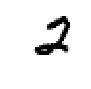

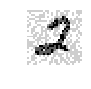

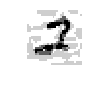

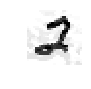

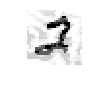

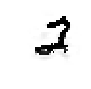

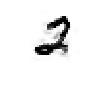

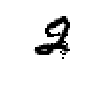

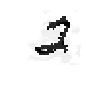

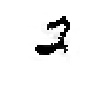

In [10]:
#Lets visualize one sample from each dataset
x_vis = np.random.choice(range(0,num_test_samples), 1)
visualize(reg_data[x_vis].reshape(*input_shape))
visualize(noisy_data[x_vis].reshape(*input_shape))
visualize(fgsm_data[x_vis].reshape(*input_shape))
visualize(bim_a_data[x_vis].reshape(*input_shape))
visualize(bim_b_data[x_vis].reshape(*input_shape))
visualize(cw_data[x_vis].reshape(*input_shape))
visualize(df_data[x_vis].reshape(*input_shape))
visualize(jsma_data[x_vis].reshape(*input_shape))
visualize(p1_cw_data[x_vis].reshape(*input_shape))
visualize(p2_cw_data[x_vis].reshape(*input_shape))

In [11]:
#Get predictions
reg_preds = model.model.predict(reg_data.reshape(-1,*input_shape))
noisy_preds = model.model.predict(noisy_data.reshape(-1,*input_shape))
fgsm_preds = model.model.predict(fgsm_data.reshape(-1,*input_shape))
bim_a_preds = model.model.predict(bim_a_data.reshape(-1,*input_shape))
bim_b_preds = model.model.predict(bim_b_data.reshape(-1,*input_shape))
cw_preds = model.model.predict(cw_data.reshape(-1,*input_shape))
df_preds = model.model.predict(df_data.reshape(-1,*input_shape))
jsma_preds = model.model.predict(jsma_data.reshape(-1,*input_shape))
p1_cw_preds = model.model.predict(p1_cw_data.reshape(-1,*input_shape))
p2_cw_preds = model.model.predict(p2_cw_data.reshape(-1,*input_shape))

In [12]:
#Convert preds to labels
reg_labels = np.zeros(reg_preds.shape)
reg_labels[np.arange(num_test_samples),np.argmax(reg_preds, axis=1)] = 1

noisy_labels = np.zeros(noisy_preds.shape)
noisy_labels[np.arange(num_test_samples),np.argmax(noisy_preds, axis=1)] = 1

fgsm_labels = np.zeros(fgsm_preds.shape)
fgsm_labels[np.arange(num_test_samples),np.argmax(fgsm_preds, axis=1)] = 1

bim_a_labels = np.zeros(bim_a_preds.shape)
bim_a_labels[np.arange(num_test_samples),np.argmax(bim_a_preds, axis=1)] = 1

bim_b_labels = np.zeros(bim_b_preds.shape)
bim_b_labels[np.arange(num_test_samples),np.argmax(bim_b_preds, axis=1)] = 1

cw_labels = np.zeros(cw_preds.shape)
cw_labels[np.arange(num_test_samples),np.argmax(cw_preds, axis=1)] = 1

df_labels = np.zeros(df_preds.shape)
df_labels[np.arange(num_test_samples),np.argmax(df_preds, axis=1)] = 1

jsma_labels = np.zeros(jsma_preds.shape)
jsma_labels[np.arange(num_test_samples),np.argmax(jsma_preds, axis=1)] = 1

p1_cw_labels = np.zeros(p1_cw_preds.shape)
p1_cw_labels[np.arange(num_test_samples),np.argmax(p1_cw_preds, axis=1)] = 1

p2_cw_labels = np.zeros(p2_cw_preds.shape)
p2_cw_labels[np.arange(num_test_samples),np.argmax(p2_cw_preds, axis=1)] = 1

In [13]:
#Check preds to ensure adversarial samples were generated correctly
print (np.argmax(reg_preds, axis=1))
print (np.argmax(noisy_preds, axis=1))
print (np.argmax(fgsm_preds, axis=1))
print (np.argmax(bim_a_preds, axis=1))
print (np.argmax(bim_b_preds, axis=1))
print (np.argmax(cw_preds, axis=1))
print (np.argmax(df_preds, axis=1))
print (np.argmax(jsma_preds, axis=1))
print (np.argmax(p1_cw_preds, axis=1))
print (np.argmax(p2_cw_preds, axis=1))

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7
 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 3]
[0 0 0 0 0 0 0 0 0 0 1 8 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7
 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 7]
[2 4 4 8 5 9 8 4 5 2 8 0 2 8 8 8 8 3 3 2 7 7 7 3 7 3 7 2 3 3 9 5 2 5 8 8 5
 9 9 8 9 9 8 2 8 9 9 8 8 7 3 3 3 3 3 3 3 8 3 5 5 0 4 5 4 5 5 6 5 8 8 9 8 3
 2 8 8 8 8 8 0 9 9 3 3 8 9 5 9 8 8 4 5 4 5 8 4 4 7 7]
[2 9 4 8 5 9 8 4 5 4 8 0 7 8 8 2 8 8 3 2 7 7 7 3 7 3 7 8 8 1 9 5 2 5 8 8 5
 9 9 8 9 9 8 2 9 9 9 8 7 7 3 3 3 3 3 3 3 8 3 9 5 0 4 5 4 5 5 5 5 8 5 9 8 3
 2 8 2 5 8 2 0 9 9 9 3 9 9 5 9 6 4 4 5 4 5 8 4 4 8 7]
[2 9 3 8 5 9 8 4 5 4 8 0 3 8 8 8 8 8 3 2 3 3 7 3 7 3 7 8 8 1 9 5 2 5 8 8 5
 9 9 8 9 9 8 2 9 9 9 8 7 7 3 3 3 3 3 3 3 2 3 9 5 0 4 5 4 5 5 5 5 2 5 9 9 3
 2 8 2 5 3 2 0 9 9 9 3 9 9 5 9 6 4

In [14]:
#Get gradients for all test points
grads_reg = model.get_gradients_wrt_params(reg_data, reg_labels)
grads_noisy = model.get_gradients_wrt_params(noisy_data, noisy_labels)
grads_fgsm = model.get_gradients_wrt_params(fgsm_data, fgsm_labels)
grads_bim_a = model.get_gradients_wrt_params(bim_a_data, bim_a_labels)
grads_bim_b = model.get_gradients_wrt_params(bim_b_data, bim_b_labels)
grads_cw = model.get_gradients_wrt_params(cw_data, cw_labels)
grads_df = model.get_gradients_wrt_params(df_data, df_labels)
grads_jsma = model.get_gradients_wrt_params(jsma_data, jsma_labels)
grads_p1_cw = model.get_gradients_wrt_params(p1_cw_data, p1_cw_labels)
grads_p2_cw = model.get_gradients_wrt_params(p2_cw_data, p2_cw_labels)

#Get gradients for training points 
grads_train = model.get_gradients_wrt_params(train_data, train_data_labels)

In [15]:
grads_reg_nm = normalize(grads_reg)
grads_noisy_nm = normalize(grads_noisy)
grads_fgsm_nm = normalize(grads_fgsm)
grads_bim_a_nm = normalize(grads_bim_a)
grads_bim_b_nm = normalize(grads_bim_b)
grads_cw_nm = normalize(grads_cw)
grads_df_nm = normalize(grads_df)
grads_jsma_nm = normalize(grads_jsma)
grads_p1_cw_nm = normalize(grads_p1_cw)
grads_p2_cw_nm = normalize(grads_p2_cw)
grads_train_nm = normalize(grads_train)

In [16]:
#Get norms 
grads_reg_norms = np.sqrt(np.dot(grads_reg, grads_reg.T)).diagonal()
grads_noisy_norms = np.sqrt(np.dot(grads_noisy, grads_noisy.T)).diagonal()
grads_bim_a_norms = np.sqrt(np.dot(grads_bim_a, grads_bim_b.T)).diagonal()
grads_bim_b_norms = np.sqrt(np.dot(grads_bim_b, grads_bim_b.T)).diagonal()
grads_fgsm_norms = np.sqrt(np.dot(grads_fgsm, grads_fgsm.T)).diagonal()
grads_cw_norms = np.sqrt(np.dot(grads_cw, grads_cw.T)).diagonal()
grads_df_norms = np.sqrt(np.dot(grads_df, grads_df.T)).diagonal()
grads_jsma_norms = np.sqrt(np.dot(grads_jsma, grads_jsma.T)).diagonal()
grads_p1_cw_norms = np.sqrt(np.dot(grads_p1_cw, grads_p1_cw.T)).diagonal()
grads_p2_cw_norms = np.sqrt(np.dot(grads_p2_cw, grads_p2_cw.T)).diagonal()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  
/usr/local/lib/python2.7/dist-packages/ipykernel_lau

In [17]:
#Get cosine similarity matrix
cos_sim_reg = np.dot(grads_reg_nm, grads_train_nm.T)
cos_sim_noisy = np.dot(grads_noisy_nm, grads_train_nm.T)
cos_sim_fgsm = np.dot(grads_fgsm_nm, grads_train_nm.T)
cos_sim_bim_a = np.dot(grads_bim_a_nm, grads_train_nm.T)
cos_sim_bim_b = np.dot(grads_bim_b_nm, grads_train_nm.T)
cos_sim_cw = np.dot(grads_cw_nm, grads_train_nm.T)
cos_sim_df = np.dot(grads_df_nm, grads_train_nm.T)
cos_sim_jsma = np.dot(grads_jsma_nm, grads_train_nm.T)
cos_sim_p1_cw = np.dot(grads_p1_cw_nm, grads_train_nm.T)
cos_sim_p2_cw = np.dot(grads_p2_cw_nm, grads_train_nm.T)

In [18]:
#Separate Using Cos Sim
eta = 0.72

count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_reg[i]) > eta:
        count+=1.0
        
print ('Regular: %.4f' % ( count/num_test_samples))

count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_noisy[i]) > eta:
        count+=1.0
    
print ('Noisy:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_fgsm[i]) > eta:
        count+=1.0
        
print ('FGSM:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_bim_a[i]) > eta:
        count+=1.0
        
print ('BIM-A:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_bim_b[i]) > eta:
        count+=1.0
        
print ('BIM-B:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_cw[i]) > eta:
        count+=1.0
    
print ('CW: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_df[i]) > eta:
        count+=1.0
    
print ('DF: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_jsma[i]) > eta:
        count+=1.0
    
print ('JSMA: %.4f' % ( count/num_test_samples))

count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_p1_cw[i]) > eta:
        count+=1.0
        
print ('1 Phase CW:  %.4f' % ( count/num_test_samples))

count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_p2_cw[i]) > eta:
        count+=1.0
        
print ('2 Phase CW:  %.4f' % ( count/num_test_samples))



Regular: 0.8500
Noisy:  0.4900
FGSM:  0.1700
BIM-A:  0.0900
BIM-B:  0.2200
CW: 0.0600
DF: 0.0200
JSMA: 0.0600
1 Phase CW:  0.1800
2 Phase CW:  0.0300


In [19]:
#Separate using just norm
gamma = .025

count = 0.0
for i in range(num_test_samples):
    if grads_reg_norms[i] < gamma:
        count+=1.0
        
print ('Regular: %.4f' % ( count/num_test_samples))

count = 0.0
for i in range(num_test_samples):
    if grads_noisy_norms[i] < gamma:
        count+=1.0
    
print ('Noisy:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_fgsm_norms[i] < gamma:
        count+=1.0
        
print ('FGSM:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_bim_a_norms[i] < gamma:
        count+=1.0
        
print ('BIM-A:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_bim_b_norms[i] < gamma:
        count+=1.0
        
print ('BIM-B:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_cw_norms[i] < gamma:
        count+=1.0
    
print ('CW: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_df_norms[i] < gamma:
        count+=1.0
    
print ('DF: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_jsma_norms[i] < gamma:
        count+=1.0
    
print ('JSMA: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_p1_cw_norms[i] < gamma:
        count+=1.0
    
print ('1 Phase CW: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_p2_cw_norms[i] < gamma:
        count+=1.0
    
print ('2 Phase CW: %.4f' % ( count/num_test_samples))


Regular: 0.8700
Noisy:  0.3400
FGSM:  0.1000
BIM-A:  0.3800
BIM-B:  0.7500
CW: 0.0000
DF: 0.0000
JSMA: 0.0000
1 Phase CW: 0.1900
2 Phase CW: 0.0000


In [20]:
#Use both cos and norm

count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_reg[i]) > eta and grads_reg_norms[i] < gamma:
        count+=1.0
        
print ('Regular: %.4f' % ( count/num_test_samples))

count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_noisy[i]) > eta and grads_noisy_norms[i] < gamma:
        count+=1.0
    
print ('Noisy:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_fgsm[i]) > eta and grads_fgsm_norms[i] < gamma:
        count+=1.0
        
print ('FGSM:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_bim_a[i]) > eta and grads_bim_a_norms[i] < gamma:
        count+=1.0
        
print ('BIM-A:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_bim_b[i]) > eta and grads_bim_b_norms[i] < gamma:
        count+=1.0
        
print ('BIM-B:  %.4f' % ( count/num_test_samples))
count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_cw[i]) > eta and grads_cw_norms[i] < gamma:
        count+=1.0
    
print ('CW: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_df[i]) > eta and grads_df_norms[i] < gamma:
        count+=1.0
    
print ('DF: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_jsma[i]) > eta and grads_jsma_norms[i] < gamma:
        count+=1.0
    
print ('JSMA: %.4f' % ( count/num_test_samples))


count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_p1_cw[i]) > eta and grads_p1_cw_norms[i] < gamma:
        count+=1.0
    
print ('1 Phase CW: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_p2_cw[i]) > eta and grads_p2_cw_norms[i] < gamma:
        count+=1.0
    
print ('2 Phase CW: %.4f' % ( count/num_test_samples))


Regular: 0.7700
Noisy:  0.2000
FGSM:  0.0400
BIM-A:  0.0300
BIM-B:  0.2000
CW: 0.0000
DF: 0.0000
JSMA: 0.0000
1 Phase CW: 0.1300
2 Phase CW: 0.0000


In [21]:
def avg_l2_distortion(orig, adv):
    """Get the mean l2 distortion between two orig and adv images"""
    l2_dist = 0.0
    for i in range(orig.shape[0]):
        l2_dist+= np.linalg.norm(orig[i] - adv[i])
    return l2_dist/orig.shape[0]

In [25]:
print (avg_l2_distortion(reg_data, noisy_data))
print (avg_l2_distortion(reg_data, fgsm_data))
print (avg_l2_distortion(reg_data, bim_a_data))
print (avg_l2_distortion(reg_data, bim_b_data))
print (avg_l2_distortion(reg_data, cw_data))
print (avg_l2_distortion(reg_data, df_data))
print (avg_l2_distortion(reg_data, jsma_data))
print (avg_l2_distortion(reg_data, p1_cw_data))
print (avg_l2_distortion(reg_data, p2_cw_data))

6.12790347543
5.76757443905
2.43369362354
4.64683722496
2.89489785492
1.58925071873
4.78481652141
4.97355137825
3.5425996691


In [23]:
count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_noisy[i]) > np.max(cos_sim_reg[i]):
        count+=1.0
    
print ('Noisy:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_fgsm[i]) > np.max(cos_sim_reg[i]):
        count+=1.0
        
print ('FGSM:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_bim_a[i])> np.max(cos_sim_reg[i]):
        count+=1.0
        
print ('BIM-A:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_bim_b[i]) > np.max(cos_sim_reg[i]):
        count+=1.0
        
print ('BIM-B:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_cw[i]) > np.max(cos_sim_reg[i]):
        count+=1.0
    
print ('CW: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_df[i]) > np.max(cos_sim_reg[i]):
        count+=1.0
    
print ('DF: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_jsma[i]) > np.max(cos_sim_reg[i]):
        count+=1.0
    
print ('JSMA: %.4f' % ( count/num_test_samples))


count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_p1_cw[i]) > np.max(cos_sim_reg[i]):
        count+=1.0
        
print ('1 Phase CW:  %.4f' % ( count/num_test_samples))

count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_p2_cw[i]) > np.max(cos_sim_reg[i]):
        count+=1.0
        
print ('2 Phase CW:  %.4f' % ( count/num_test_samples))



Noisy:  0.1100
FGSM:  0.0600
BIM-A:  0.0700
BIM-B:  0.1100
CW: 0.0500
DF: 0.0500
JSMA: 0.0300
1 Phase CW:  0.0900
2 Phase CW:  0.0300


In [26]:
count = 0.0
for i in range(num_test_samples):
    if grads_noisy_norms[i] < grads_reg_norms[i]:
        count+=1.0
    
print ('Noisy:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_fgsm_norms[i] < grads_reg_norms[i]:
        count+=1.0
        
print ('FGSM:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_bim_a_norms[i] < grads_reg_norms[i]:
        count+=1.0
        
print ('BIM-A:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_bim_b_norms[i] < grads_reg_norms[i]:
        count+=1.0
        
print ('BIM-B:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_cw_norms[i] < grads_reg_norms[i]:
        count+=1.0
    
print ('CW: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_df_norms[i] < grads_reg_norms[i]:
        count+=1.0
    
print ('DF: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_jsma_norms[i] < grads_reg_norms[i]:
        count+=1.0
    
print ('JSMA: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_p1_cw_norms[i] <grads_reg_norms[i]:
        count+=1.0
    
print ('1 Phase CW: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_p2_cw_norms[i] < grads_reg_norms[i]:
        count+=1.0
    
print ('2 Phase CW: %.4f' % ( count/num_test_samples))

Noisy:  0.0600
FGSM:  0.0500
BIM-A:  0.1000
BIM-B:  0.4400
CW: 0.0000
DF: 0.0000
JSMA: 0.0100
1 Phase CW: 0.0400
2 Phase CW: 0.0000
